# Plot Events
______

This notebook allows one to visualize events, including jets and the genParticles they are matched to. Trees from events are also printed using the `printTrees` method in `utils`.

In [1]:
# IMPORTS
import uproot
from coffea.nanoevents import NanoEventsFactory
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import particle
from utils import printTrees
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
# file must be nanoAOD
filepath = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0004.root"
# process events into NanoAODSchema
events = NanoEventsFactory.from_root(filepath, 
                                     treepath="Events", 
                                     entry_stop=5000).events()

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


In [3]:
# filter electrons, muons by pT
selected_electrons = events.Electron[events.Electron.pt > 30]
selected_muons = events.Muon[events.Muon.pt > 30]

# filter jets by pT
jet_filter = events.Jet.pt > 30
selected_jets = events.Jet[jet_filter]

# get genParticles
selected_genpart = events.GenPart

# single lepton requirement
event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)

# at least four jets
event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)

# at least one b-tagged jet ("tag" means score above threshold)
B_TAG_THRESHOLD = 0.8
event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

# apply event filters
selected_events = events[event_filters]
selected_electrons = selected_electrons[event_filters]
selected_muons = selected_muons[event_filters]
selected_jets = selected_jets[event_filters]
selected_genpart = selected_genpart[event_filters]

# consider 4j2b region (at least 4 jets, >=2 b-tagged jets)
region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
selected_jets_region = selected_jets[region_filter]
selected_electrons_region = selected_electrons[region_filter]
selected_muons_region = selected_muons[region_filter]
selected_genpart_region = selected_genpart[region_filter]

In [4]:
## filter genParticles to "matchable" particles

# make sure parent is not None
genpart_parent = selected_genpart_region.distinctParent
genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
selected_genpart_region_reduced = selected_genpart_region[genpart_filter]
genpart_parent_reduced = selected_genpart_region_reduced.distinctParent

# parent must be top quark or W boson
genpart_filter2 = ((np.abs(genpart_parent_reduced.pdgId)==6) | 
                   (np.abs(genpart_parent_reduced.pdgId)==24))
selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter2]

# make sure particle is a quark
genpart_filter3 = ((np.abs(selected_genpart_region_reduced.pdgId)<9) & 
                   (np.abs(selected_genpart_region_reduced.pdgId)>0))
selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter3]

# get rid of copies
genpart_filter4 = selected_genpart_region_reduced.hasFlags("isLastCopy")
selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter4]

In [5]:
# plotting candidates include daughters of t/W or t/W (remove copies) 
plotting_candidates = selected_genpart_region[genpart_filter]
genpart_filter_plotting = ((((np.abs(plotting_candidates.pdgId)<=5) & 
                           ((np.abs(plotting_candidates.distinctParent.pdgId)==24) | 
                            (np.abs(plotting_candidates.distinctParent.pdgId)==6))) | 
                           (np.abs(plotting_candidates.pdgId)==24) | 
                            (np.abs(plotting_candidates.pdgId)==6)) & 
                           (plotting_candidates.hasFlags("isLastCopy")) & 
                           (np.abs(plotting_candidates.pdgId)>0))
plotting_candidates = plotting_candidates[genpart_filter_plotting]

In [6]:
# list of all quarks (no requirement on parentage)
quark_filter = ((np.abs(selected_genpart_region.pdgId)<=9) & 
                      selected_genpart_region.hasFlags("isLastCopy"))
all_quarks= selected_genpart_region[quark_filter]

In [7]:
# find labels using pdgid of parent of nearest genPart
nearest_genpart = selected_jets_region.nearest(selected_genpart_region_reduced, 
                                               threshold=0.4)
nearest_parent = nearest_genpart.distinctParent
nearest_parent_pdgid = nearest_parent.pdgId

In [8]:
# jet colors for plotting
jetcolors = ['brown','red','orange',
             'darkgreen','teal','dodgerblue',
             'blue','blueviolet','purple','deeppink']

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 0                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   ├── t
│   │   ├── W+
│   │   │   └── W+
│   │   │       ├── mu+
│   │   │       └── nu(mu)
│   │   └── b
│   │       ├── b
│   │       └── g
│   └── B*-
│       └── B-
│           ├── nu(mu)~
│           ├── mu-
│           └── D0
├── t~
│   └── t~
│       ├── W-
│       │   ├── tau-
│       │   │   ├── nu(tau)
│       │   │   ├── pi0
│       │   │   │   ├── gamma
│       │   │   │   └── gamma
│       │   │   ├── pi0
│       │   │   │   ├── gamma
│       │   │   │   └── gamma
│       │   │   └── pi-
│       │   └── nu(tau)~
│       └── b~
└── g
    ├── g
    │   └── u~
    └── g
g
----------------------

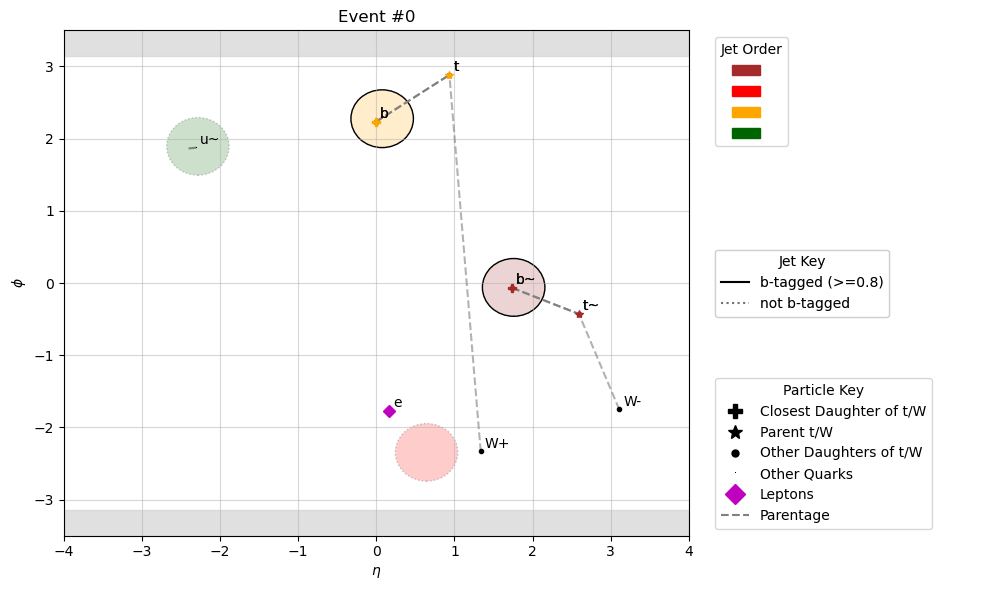

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 1                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   ├── t
│   │   ├── W+
│   │   │   └── W+
│   │   │       ├── d~
│   │   │       │   └── d~
│   │   │       └── c
│   │   │           ├── c
│   │   │           └── D*(2010)+
│   │   │               └── D0
│   │   │                   └── pi0
│   │   │                       └── gamma
│   │   └── b
│   │       ├── b
│   │       └── g
│   ├── B(s)~0
│   │   ├── nu(mu)
│   │   ├── mu+
│   │   └── D(s)*-
│   │       └── D(s)-
│   │           ├── tau-
│   │           │   ├── nu(tau)
│   │           │   ├── mu-
│   │           │   └── nu(mu)~
│   │           └── nu(tau)~
│   └── B*0
│       └── B0
│           ├──

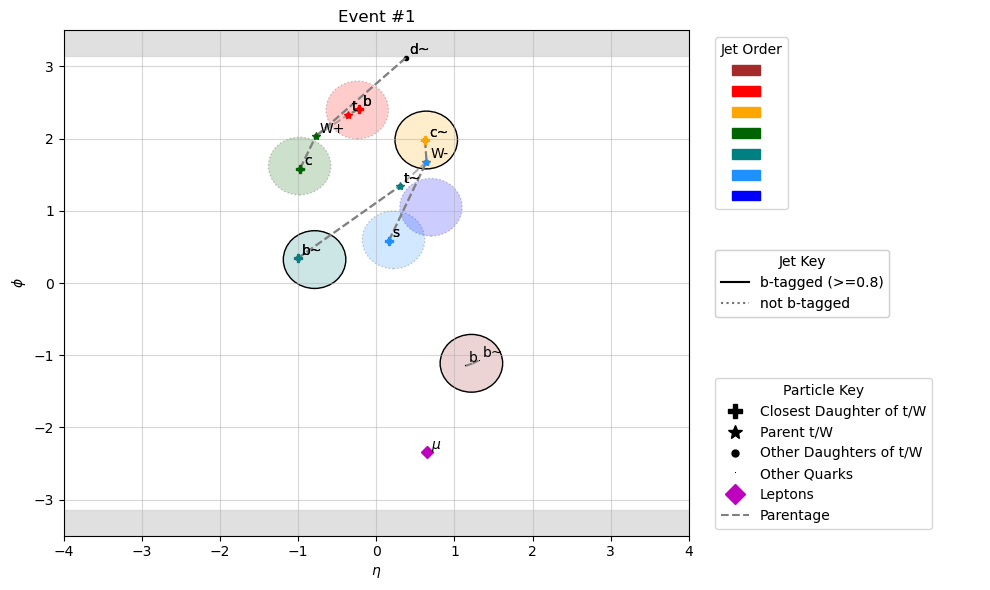

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 2                                         
-----------------------------------------------------------------------------------------------
u~
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── g
│       │       │   └── s~
│       │       └── c
│       │           ├── c
│       │           ├── g
│       │           ├── D+
│       │           │   ├── mu+
│       │           │   └── nu(mu)
│       │           └── pi0
│       │               └── gamma
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   ├── nu(mu)~
│                   ├── mu-
│                   └── D(2)*(2460)0
│                       └── D*(2010)+
│                           └── D0
│                 

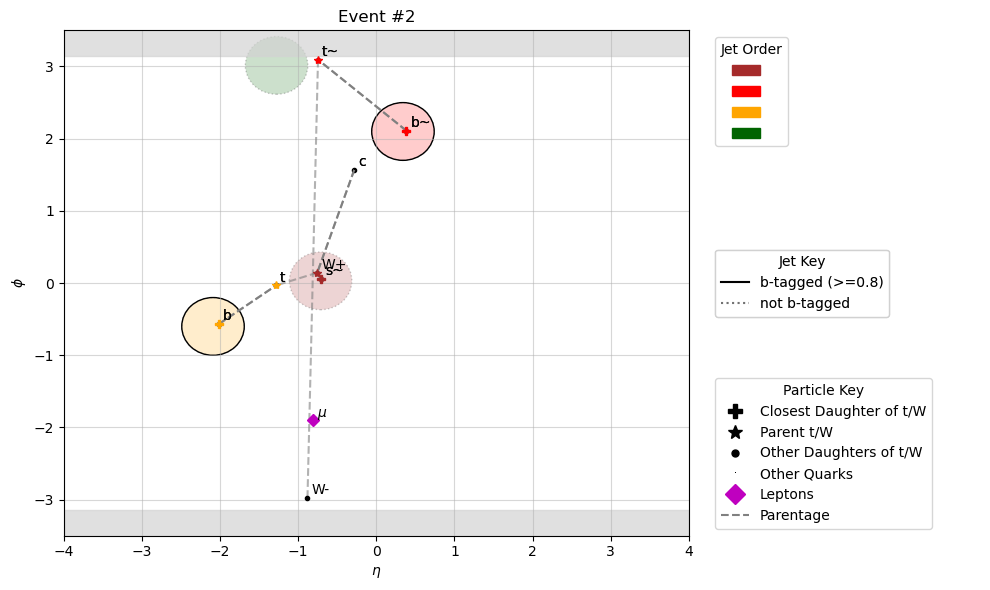

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 3                                         
-----------------------------------------------------------------------------------------------
u
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   └── s~
│       │       └── u
│       │           ├── u
│       │           └── g
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   ├── D*(2010)-
│                   │   └── D-
│                   │       ├── e-
│                   │       └── nu(e)~
│                   └── D*(2010)+
│                       └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   └── d
│       │       └── u~
│       │           ├── g
│       │       

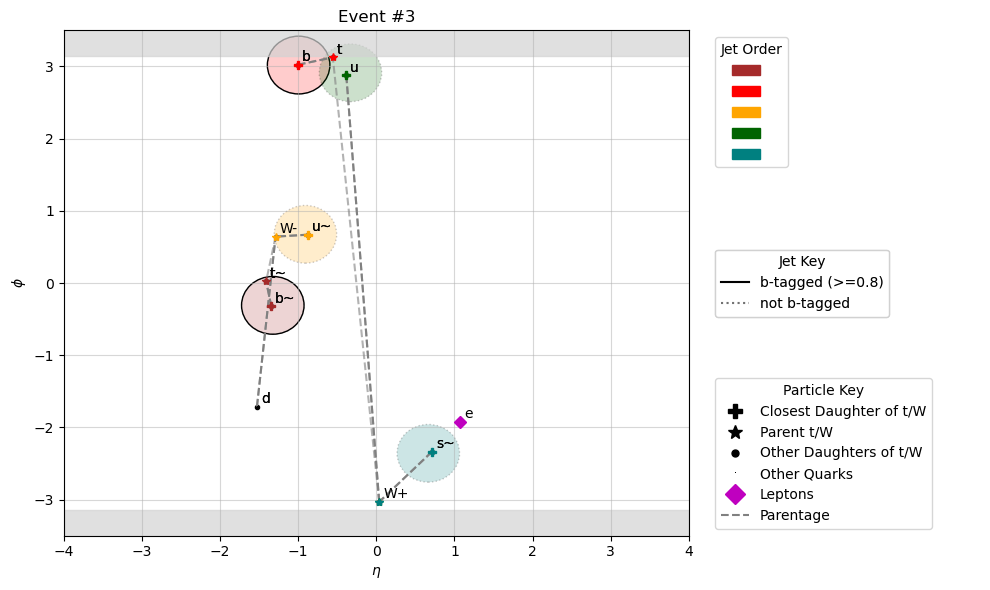

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 4                                         
-----------------------------------------------------------------------------------------------
d~
├── t
│   └── t
│       ├── W+
│       │   ├── d~
│       │   │   └── d~
│       │   └── u
│       │       └── u
│       └── b
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   └── D*(2010)-
│       │       │       └── D~0
│       │       │           ├── mu-
│       │       │           └── nu(mu)~
│       │       └── c~
│       │           ├── g
│       │           ├── g
│       │           └── c~
│       └── b~
│           ├── b~
│           └── B*+
│               └── B+
│                   ├── nu(mu)
│                   ├── mu+
│           

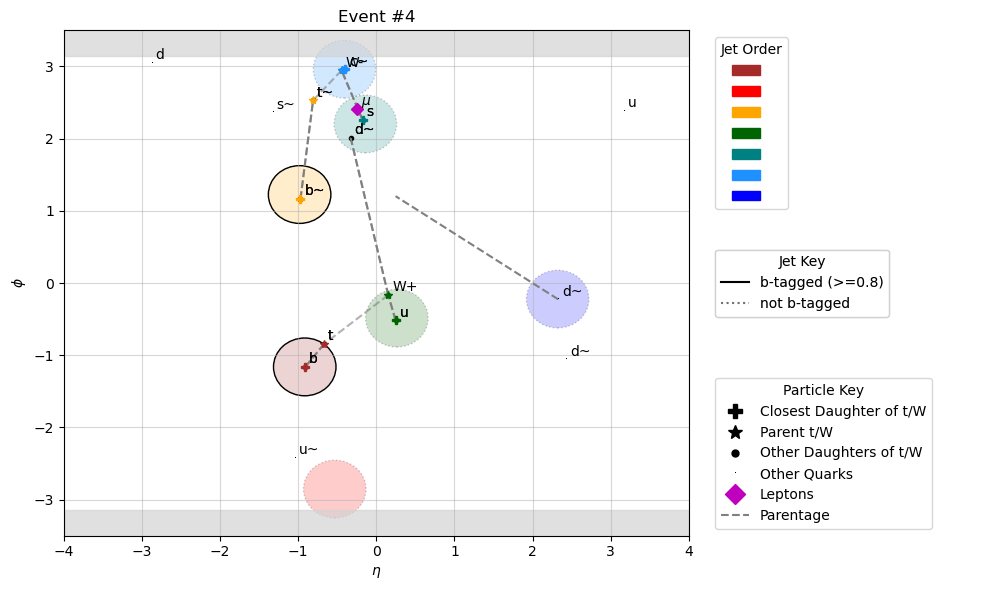

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 5                                         
-----------------------------------------------------------------------------------------------
d~
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── d~
│       │       │   └── d~
│       │       └── u
│       │           └── u
│       └── b
│           └── b
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   └── d
│       │       └── u~
│       │           └── u~
│       └── b~
│           ├── g
│           │   └── B*+
│           │       └── B+
│           │           ├── nu(mu)
│           │           ├── mu+
│           │           └── D~0
│           └── b~
└── g
    ├── g
    │   └── B*-
    │       └── B-
    │           ├── D+
    │        

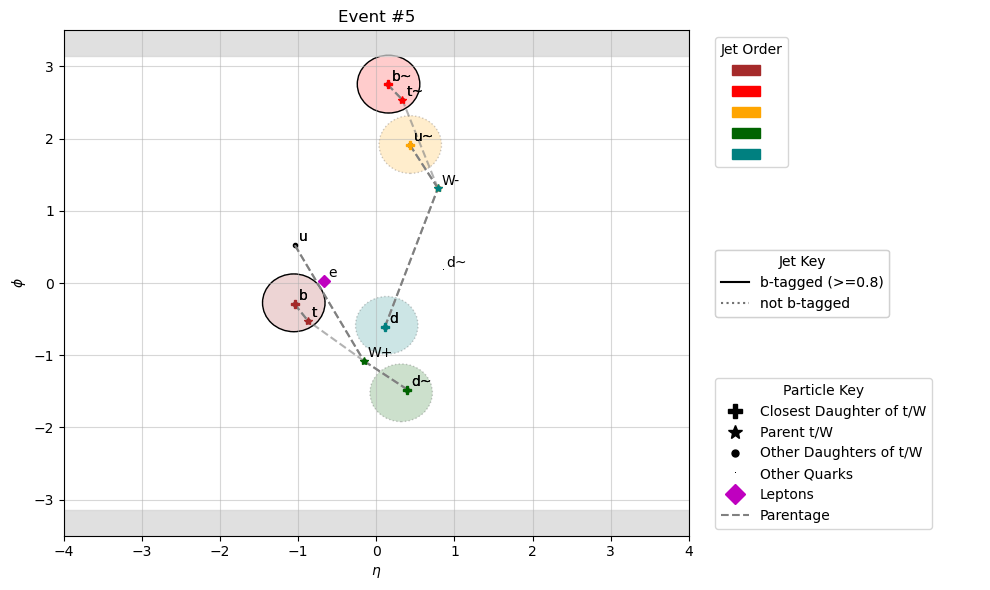

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 6                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── e+
│       │       └── nu(e)
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   ├── D*(2007)0
│                   │   └── D0
│                   └── D-
├── t~
│   └── t~
│       ├── W-
│       │   ├── d
│       │   │   ├── d
│       │   │   └── g
│       │   └── u~
│       │       └── u~
│       └── b~
└── g
    ├── g
    └── g
g
d
├── e-
└── e+
u~
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------

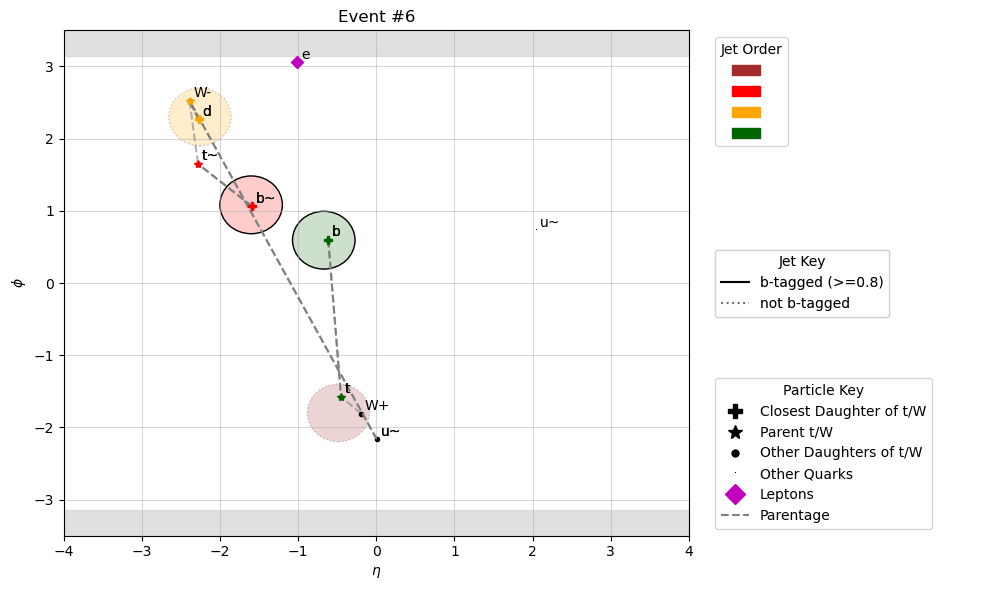

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 7                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── d~
│       │       │   └── d~
│       │       └── u
│       │           └── u
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   └── Lambda(c)+
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   ├── d
│       │       │   ├── pi0
│       │       │   │   └── gamma
│       │       │   ├── e-
│       │       │   └── e+
│       │       └── u~
│       │           ├── g
│       │           └── u~
│       └── b~
│           ├── b~
│           ├── B-
│           │  

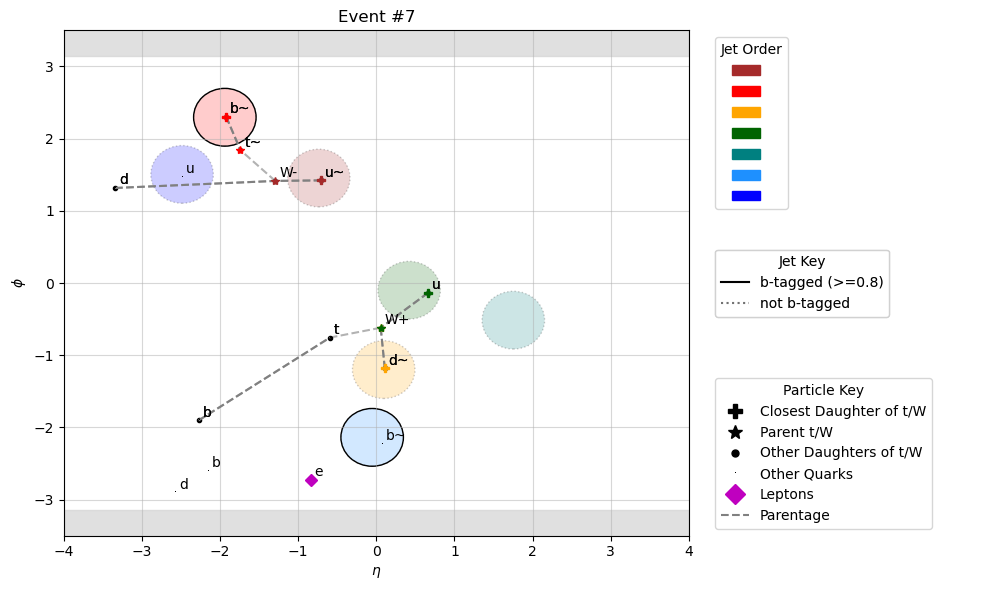

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 8                                         
-----------------------------------------------------------------------------------------------
d
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── c
│       │       │   ├── s~
│       │       │   └── Lambda(c)+
│       │       └── c
│       └── b
│           ├── g
│           ├── b
│           └── B*-
│               └── B-
│                   ├── nu(e)~
│                   ├── e-
│                   └── D*(2007)0
│                       └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   └── d
│       │       └── u~
│       │           ├── g
│       │           └── u~
│       └── b~
│           └── b~
└── g
    ├

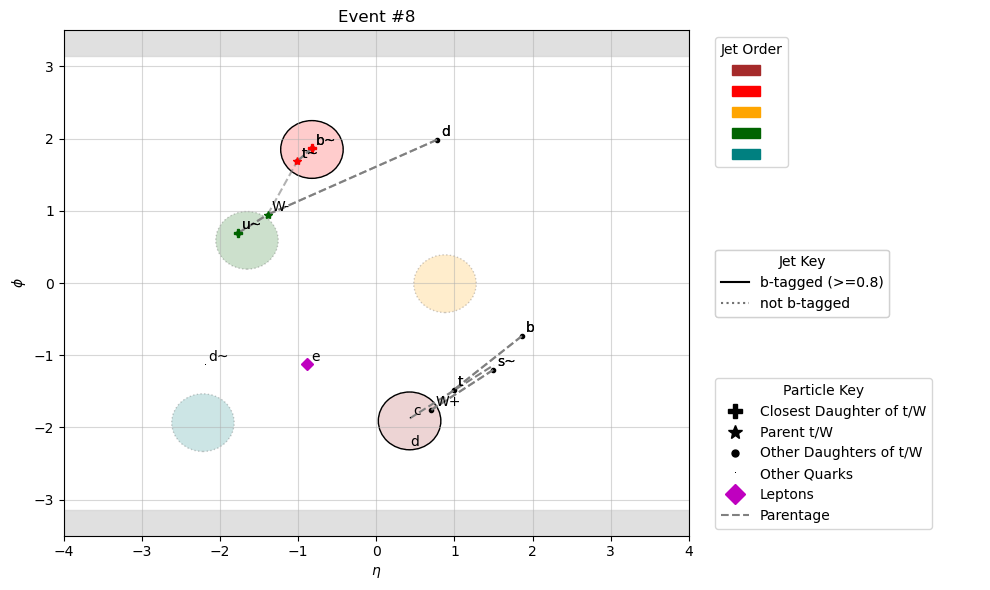

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 9                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── mu+
│       │       └── nu(mu)
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   ├── nu(e)~
│                   ├── e-
│                   └── D*(2007)0
│                       └── D0
│                           ├── mu+
│                           └── nu(mu)
├── t~
│   ├── t~
│   │   ├── W-
│   │   │   └── W-
│   │   │       ├── d
│   │   │       │   └── d
│   │   │       └── u~
│   │   │           ├── g
│   │   │           ├── g
│   │   │           ├── g
│   │   │           └── u~
│   │   └── b~
│  

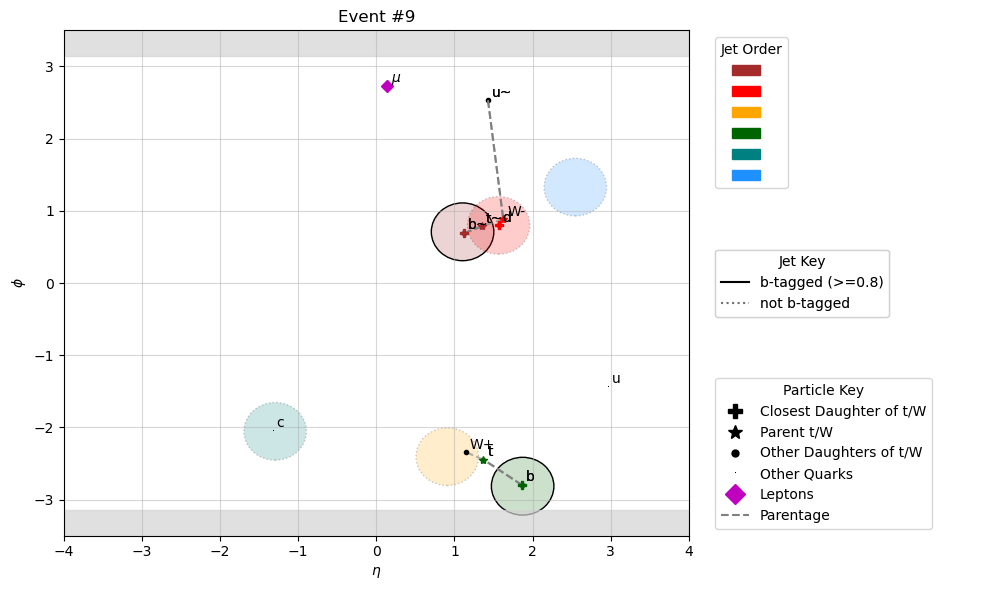

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 10                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── d~
│       │       │   ├── g
│       │       │   ├── d~
│       │       │   ├── pi0
│       │       │   │   ├── gamma
│       │       │   │   └── gamma
│       │       │   └── pi0
│       │       │       └── gamma
│       │       └── u
│       │           └── u
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   └── D*(2010)+
│                       └── D+
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   └── D*(2010)-
│       │  

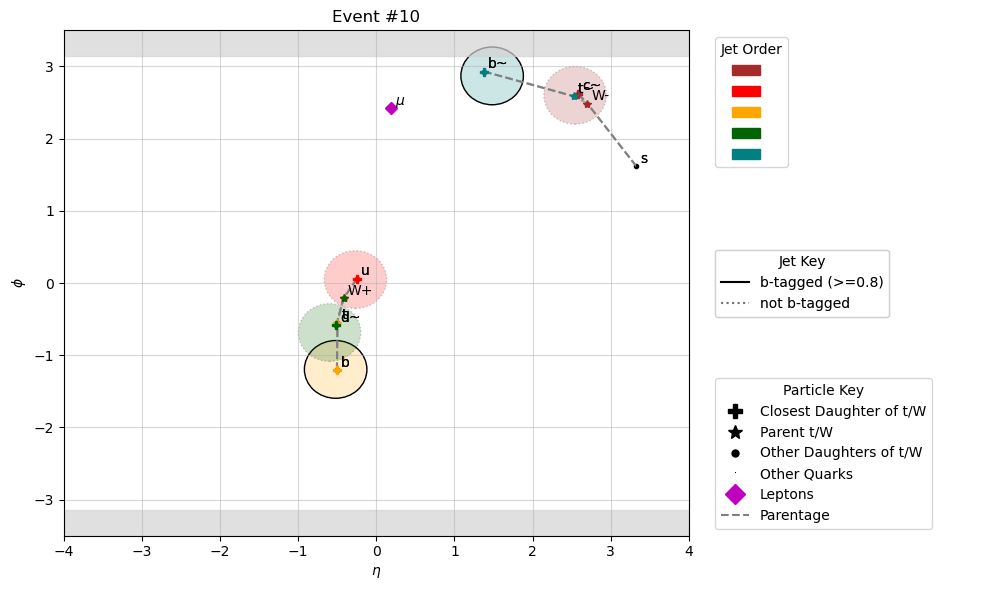

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 11                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── tau+
│       │       │   ├── nu(tau)~
│       │       │   ├── pi+
│       │       │   ├── pi+
│       │       │   └── pi-
│       │       └── nu(tau)
│       └── b
│           ├── b
│           ├── B~0
│           │   ├── D(s)*-
│           │   │   └── D(s)-
│           │   └── D*(2010)+
│           │       └── D0
│           │           ├── mu+
│           │           └── nu(mu)
│           ├── u
│           ├── e-
│           └── e+
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   └── s
│       │ 

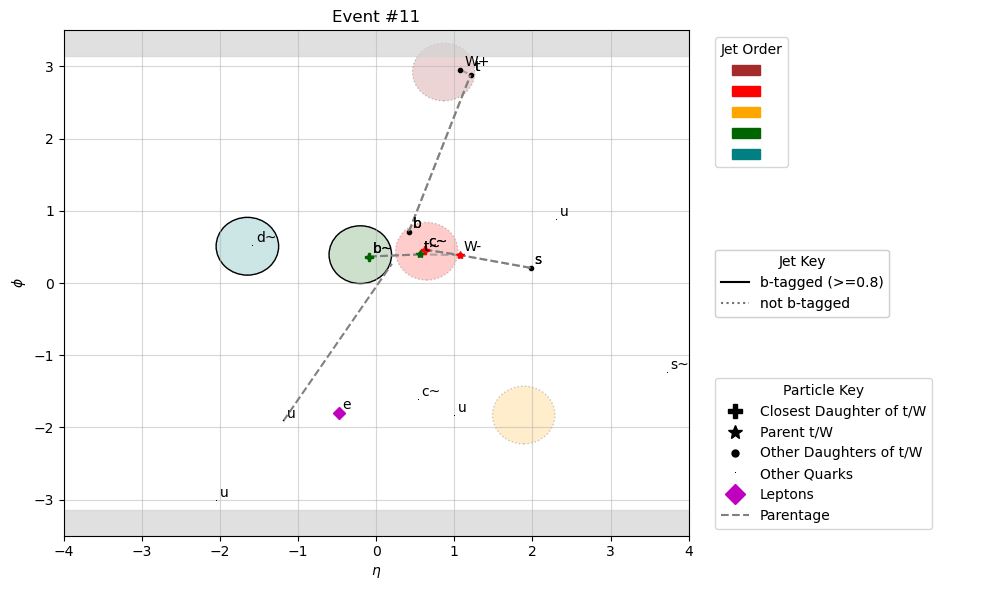

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 12                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── mu+
│       │       └── nu(mu)
│       └── b
│           ├── b
│           ├── g
│           ├── g
│           └── B*-
│               └── B-
│                   ├── D*(2007)~0
│                   │   └── D~0
│                   └── D0
│                       ├── e+
│                       └── nu(e)
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── mu-
│       │       └── nu(mu)~
│       └── b~
│           ├── b~
│           └── B*+
│               └── B+
│                   ├── D(s)*+
│                   │   └── D(s)+
│ 

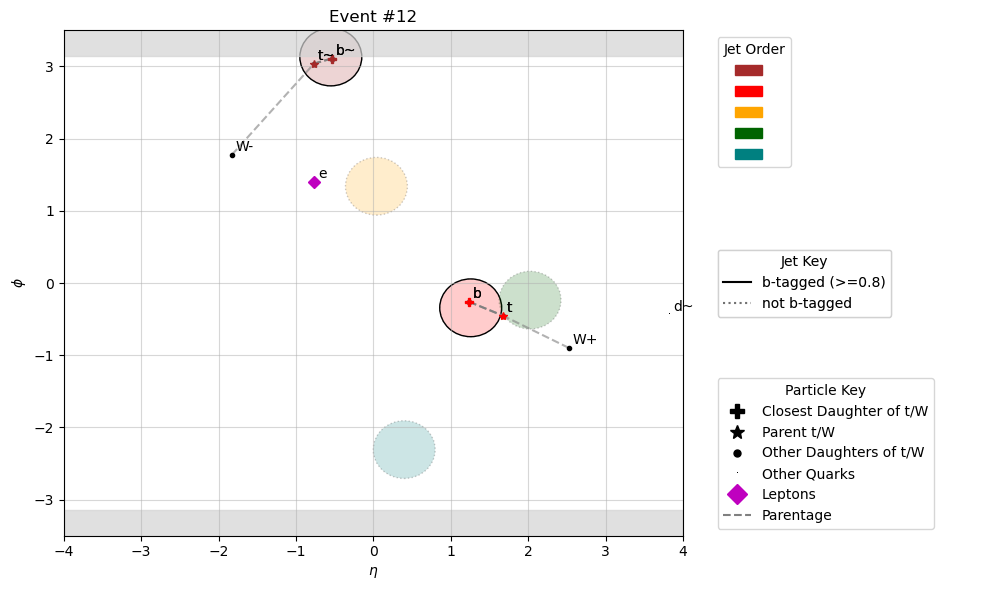

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 13                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── e+
│       │       └── nu(e)
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   ├── D(s)*+
│                   │   └── D(s)+
│                   └── D-
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── e-
│       │       │   └── gamma
│       │       └── nu(e)~
│       └── b~
│           ├── g
│           └── b~
└── u
    ├── u
    ├── u
    ├── B*+
    │   └── B+
    │       └── D*(2007)~0
    │           └── D~0
    ├── e-
    └── e+
u
gamma
-----------------------------------

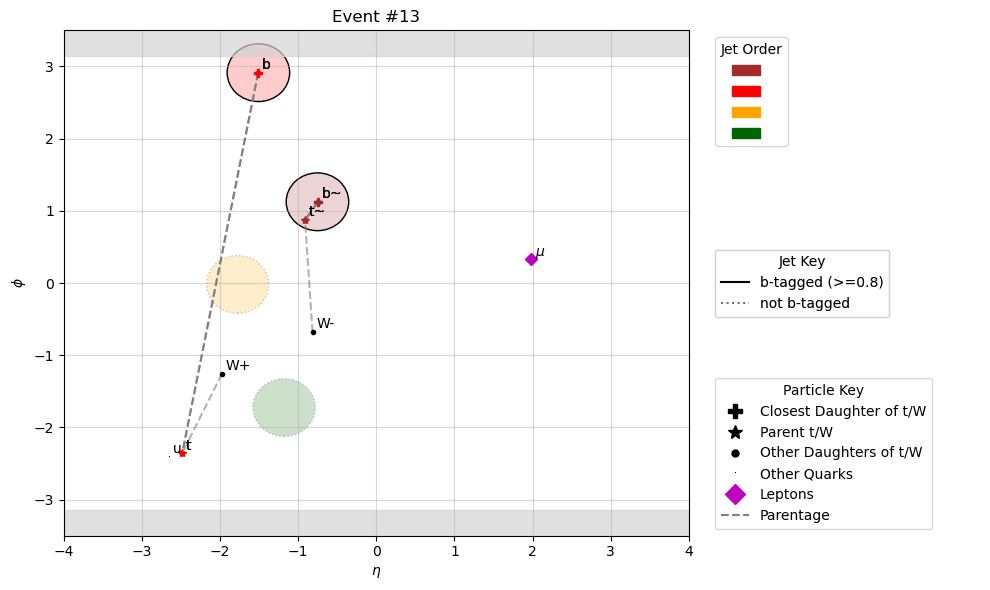

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 14                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── g
│       │       │   ├── s~
│       │       │   ├── D0
│       │       │   └── pi0
│       │       │       └── gamma
│       │       └── c
│       │           └── c
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   ├── D+
│                   └── pi0
│                       └── gamma
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   ├── d
│       │       │   ├── pi0
│       │       │   │   ├── gamma
│       │       │   │   └── 

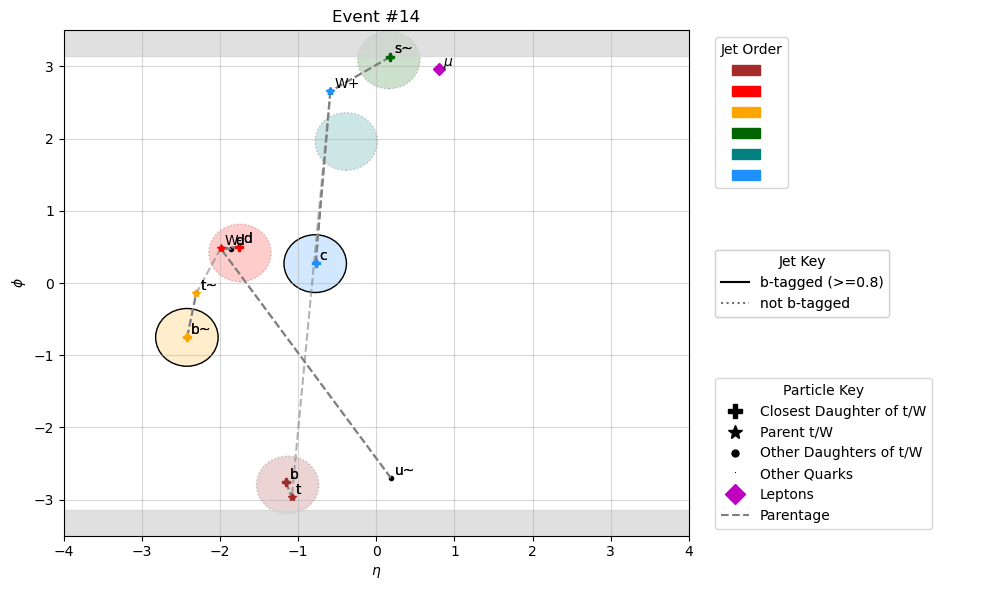

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 15                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   ├── t
│   │   ├── W+
│   │   │   └── W+
│   │   │       ├── e+
│   │   │       │   └── gamma
│   │   │       └── nu(e)
│   │   └── b
│   │       └── b
│   └── gamma
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   ├── d
│       │       │   ├── eta
│       │       │   │   ├── gamma
│       │       │   │   └── gamma
│       │       │   ├── pi0
│       │       │   │   └── gamma
│       │       │   └── pi0
│       │       │       └── gamma
│       │       └── u~
│       │           └── u~
│       └── b~
│           ├── b~
│           └── B*+
│               └── 

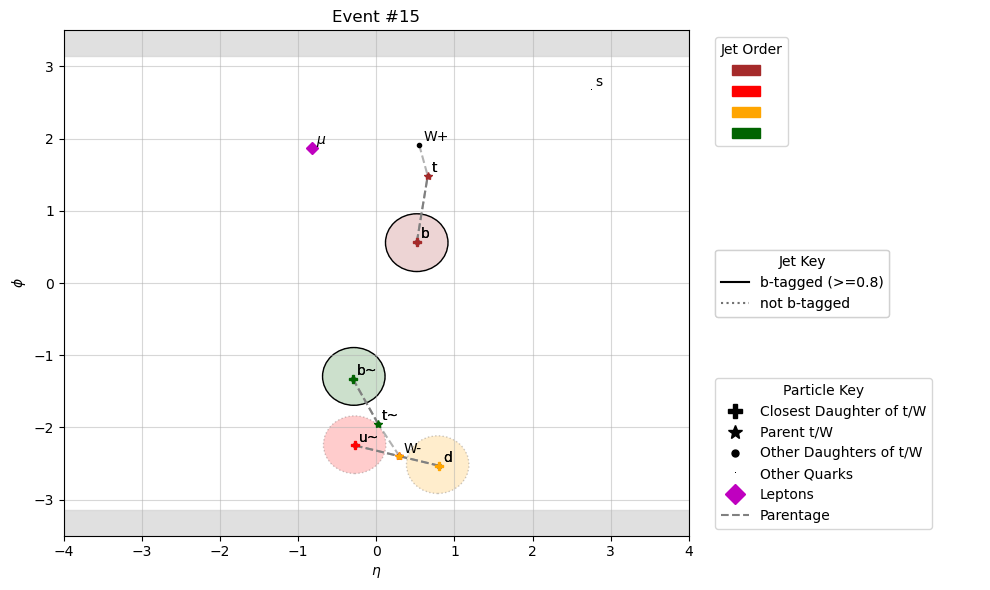

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 16                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   └── s
│       │       └── c~
│       │           ├── c~
│       │           └── D(s)*-
│       │               └── D(s)-
│       └── b~
│           └── b~
└── u
    ├── u
    ├── g
    ├── B+
    │   ├── nu(e)
    │   └── e+
    └── pi0
        └── gamma
u
d
├── e-
└── e+
d~
g
u
├── e-
└── e+
s~
-----------------------------------------------------------------------------------------------

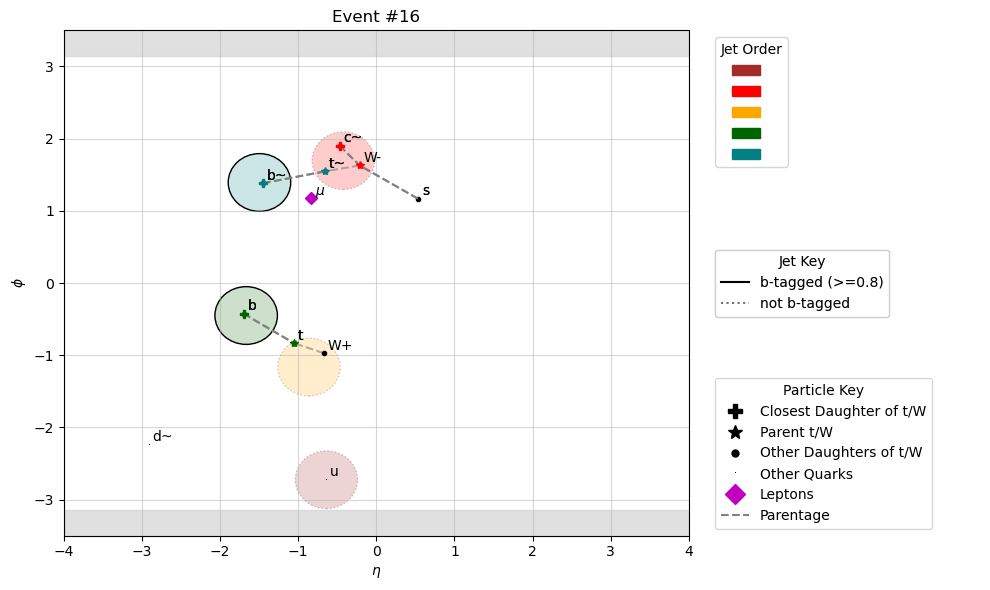

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 17                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── d~
│       │       │   ├── g
│       │       │   ├── d~
│       │       │   ├── e-
│       │       │   └── e+
│       │       └── u
│       │           ├── u
│       │           ├── g
│       │           └── g
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   ├── D(s)*-
│                   │   └── D(s)-
│                   └── D*(2007)0
│                       └── D0
│                           └── pi0
│                               └── gamma
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│   

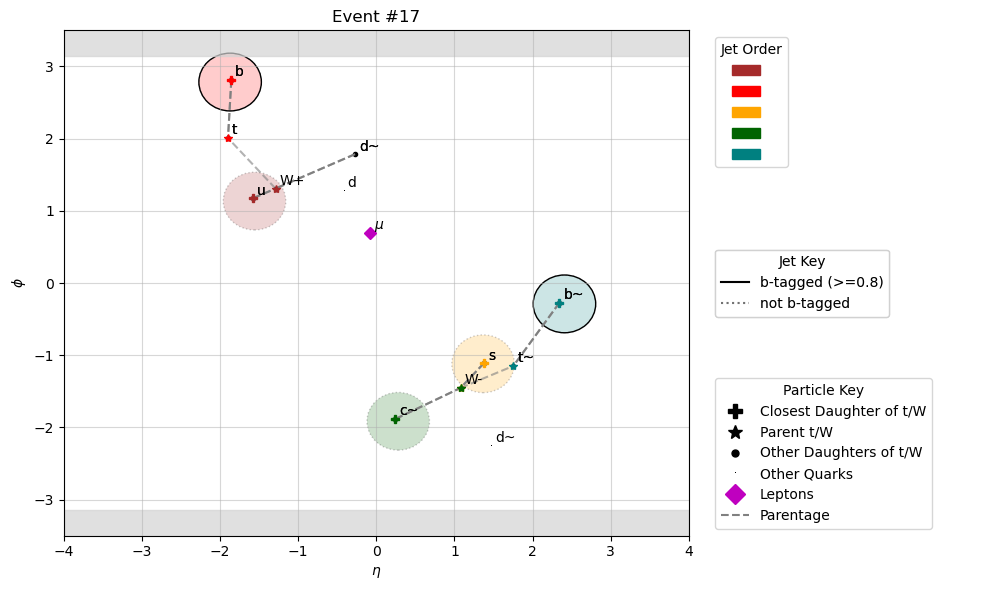

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 18                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── d~
│       │       │   └── d~
│       │       └── u
│       │           ├── u
│       │           ├── g
│       │           ├── pi0
│       │           │   └── gamma
│       │           └── pi0
│       │               └── gamma
│       └── b
│           ├── b
│           └── B~0
│               ├── nu(e)~
│               ├── e-
│               └── D+
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── mu-
│       │       └── nu(mu)~
│       └── b~
│           ├── b~
│           └── B(s)0
│               └── D(s)-
└── g
    

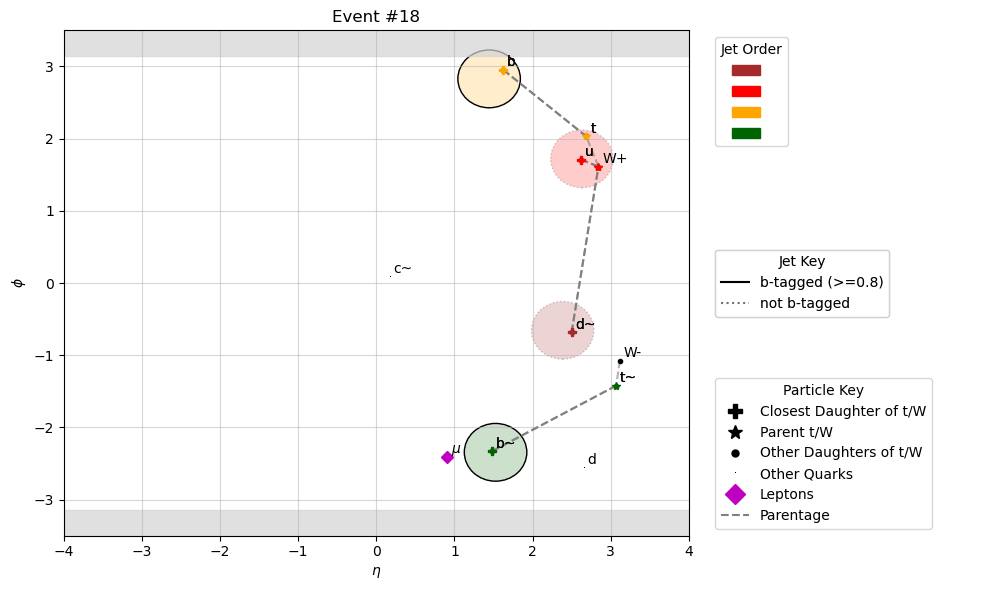

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 19                                         
-----------------------------------------------------------------------------------------------
u
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── mu+
│       │       │   └── gamma
│       │       └── nu(mu)
│       └── b
│           ├── b
│           └── B~0
│               ├── D(s)*-
│               │   └── D(s)-
│               └── D+
├── t~
│   └── t~
│       ├── W-
│       └── b~
│           ├── g
│           └── b~
└── u
    ├── u
    ├── g
    └── B*+
        └── B+
            ├── D(s)*+
            │   └── D(s)+
            │       └── pi0
            │           └── gamma
            └── D-
g
s
├── e-
└── e+
g
d~
u
├── e-
└── e+
g
g
g
u~
----------------------------------------

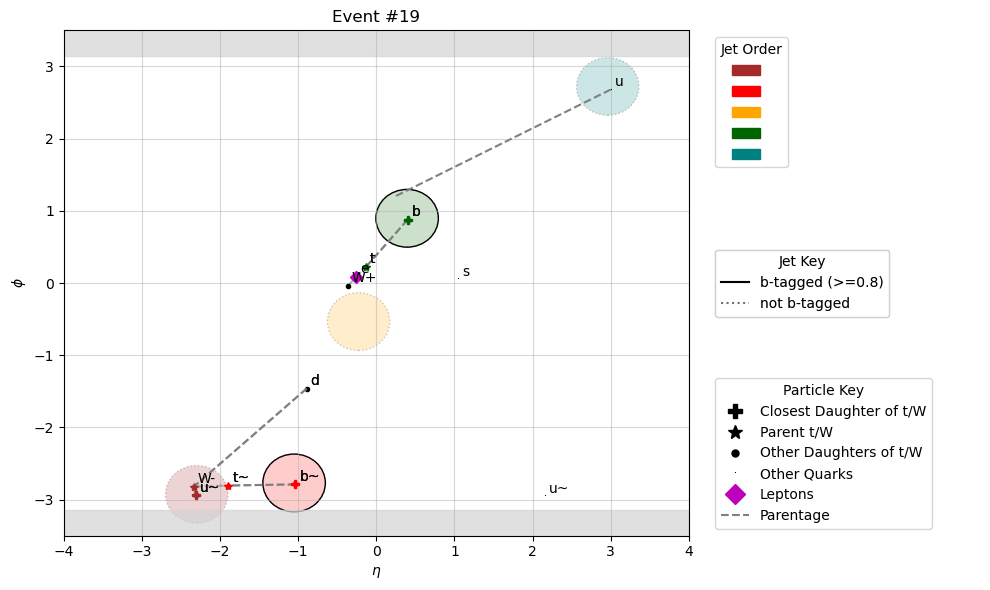

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 20                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   ├── D(s)-
│                   └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   └── d
│       │       └── u~
│       │           └── u~
│       └── b~
│           ├── b~
│           └── B(s)0
│               └── D(s)*-
│                   └── D(s)-
└── g
    ├── g
    ├── g
    ├── g
    ├── g
    ├── g
    ├── g
    ├── g
    ├── g
    └── g
g
-----------------------------------------------------------------------------------------------

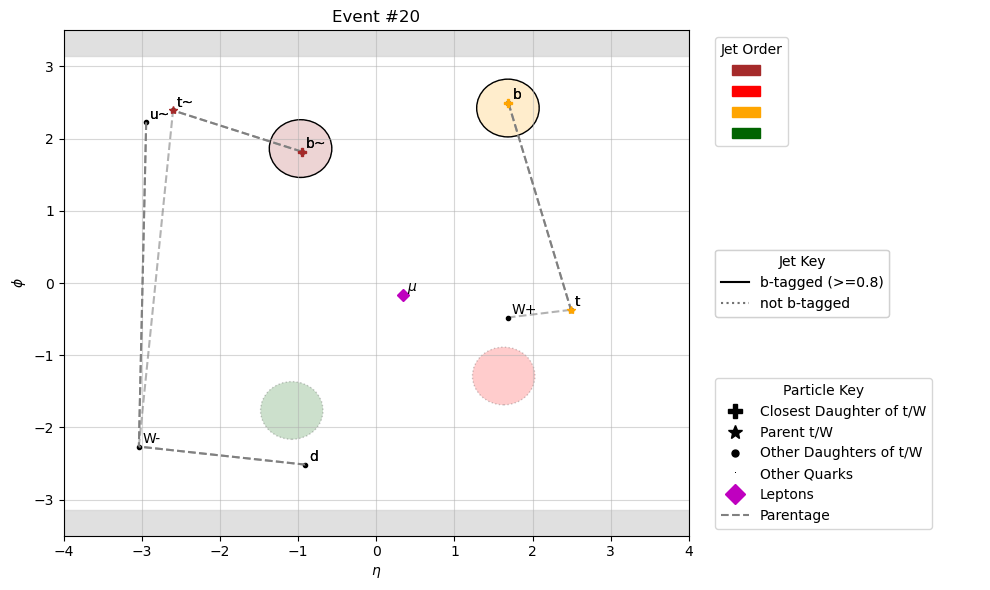

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 21                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── e+
│       │       │   ├── e+
│       │       │   └── gamma
│       │       └── nu(e)
│       │           └── nu(e)
│       └── b
│           ├── D*(2010)-
│           │   └── D~0
│           ├── b
│           └── B(s)*~0
│               └── B(s)~0
│                   └── D(s)*-
│                       └── D(s)-
│                           ├── pi0
│                           │   └── gamma
│                           └── pi0
│                               └── gamma
├── t~
│   └── t~
│       ├── W-
│       └── b~
│           └── b~
└── g
    ├─

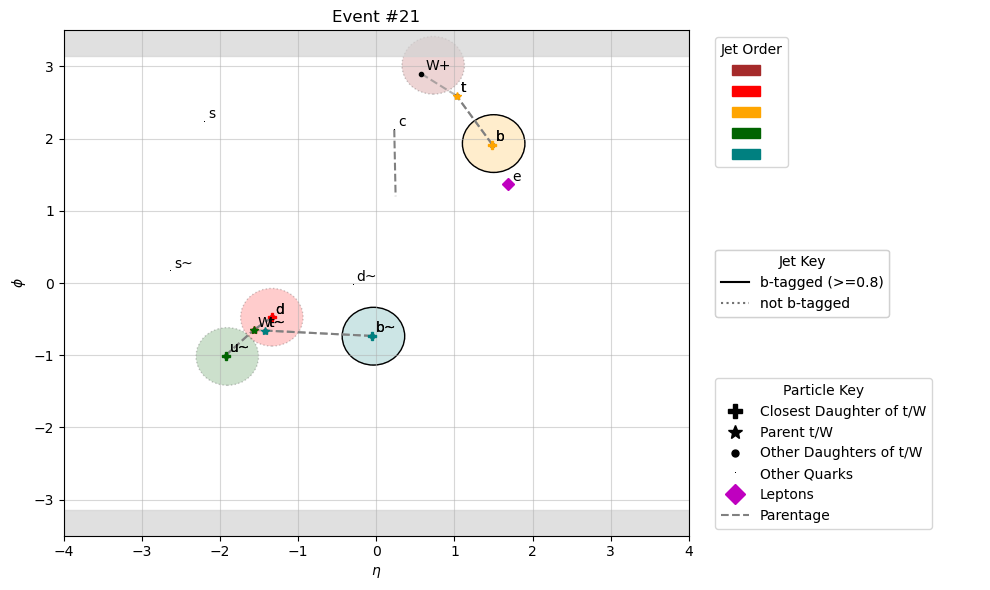

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 22                                         
-----------------------------------------------------------------------------------------------
u
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── tau+
│       │       │   ├── nu(tau)~
│       │       │   ├── pi+
│       │       │   ├── pi+
│       │       │   └── pi-
│       │       └── nu(tau)
│       └── b
│           ├── b
│           └── Sigma(b)+
│               └── Lambda(b)0
│                   └── Lambda(c)+
├── t~
│   ├── t~
│   │   ├── W-
│   │   │   └── W-
│   │   │       ├── mu-
│   │   │       └── nu(mu)~
│   │   └── b~
│   │       └── b~
│   └── B0
│       ├── D(s)+
│       └── D*(2010)-
│           └── D~0
└── g
    ├── g
    ├── g
    ├── g
    ├── g
    └── g
u~
s
├── e

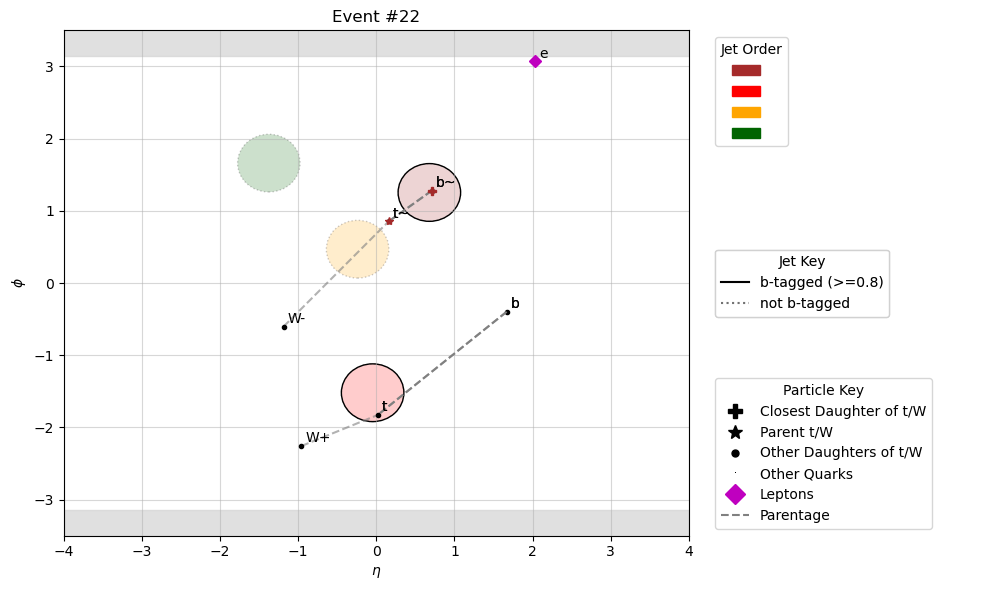

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 23                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── mu+
│       │       │   └── gamma
│       │       └── nu(mu)
│       └── b
│           ├── b
│           ├── g
│           ├── B*~0
│           │   └── B~0
│           │       └── D*(2010)+
│           │           └── D0
│           ├── e-
│           └── e+
├── t~
│   └── t~
│       ├── W-
│       └── b~
│           ├── b~
│           └── B0
│               ├── D0
│               └── D*(2010)-
│                   └── D~0
└── g
    ├── g
    ├── g
    ├── g
    ├── g
    └── g
g
g
u~
------------------------------------------------------------

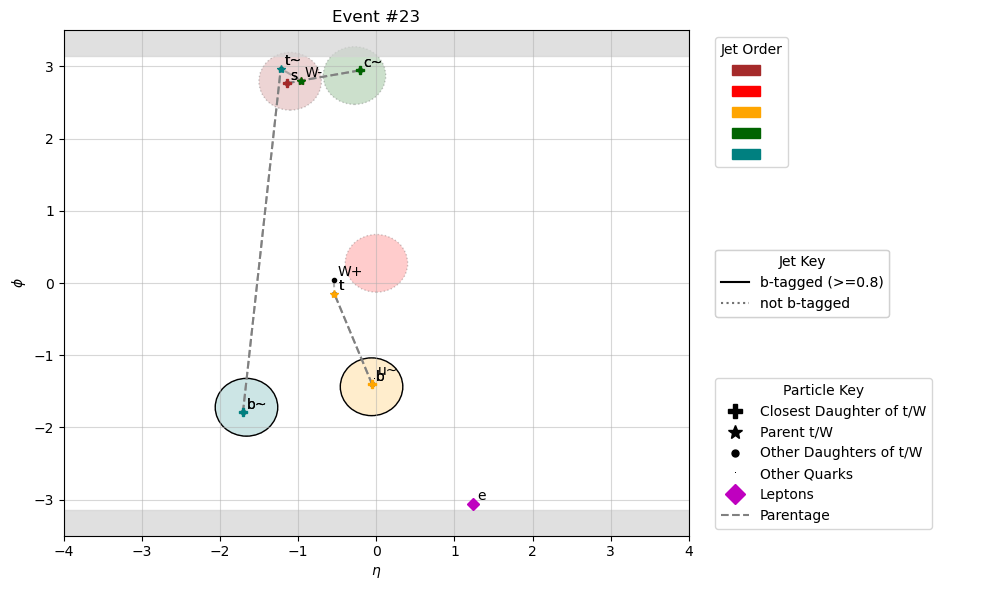

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 24                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── mu+
│       │       └── nu(mu)
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   ├── D(s)*-
│                   │   └── D(s)-
│                   └── D*(2007)0
│                       └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   └── D~0
│       │       └── c~
│       │           └── c~
│       └── b~
│           ├── g
│           ├── b~
│           ├── eta
│           │   └── gamma
│           └── B*0
│               └

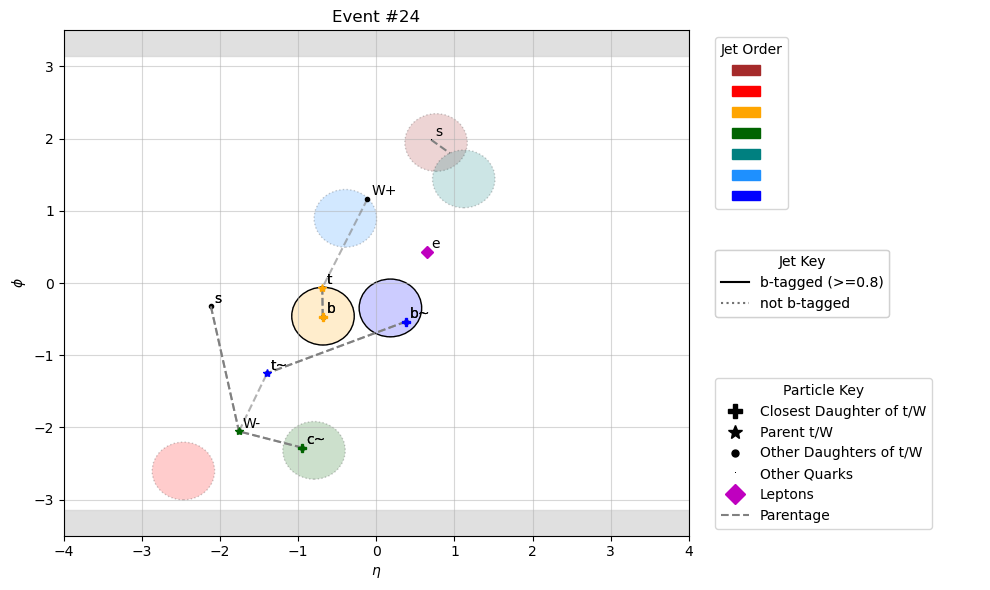

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 25                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── e+
│       │       │   └── gamma
│       │       └── nu(e)
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   └── Lambda(c)+
├── t~
│   ├── t~
│   │   ├── W-
│   │   │   ├── s
│   │   │   │   ├── s
│   │   │   │   ├── D*(2007)~0
│   │   │   │   │   └── D~0
│   │   │   │   ├── c
│   │   │   │   ├── D0
│   │   │   │   ├── D-
│   │   │   │   │   └── pi0
│   │   │   │   │       └── gamma
│   │   │   │   ├── e-
│   │   │   │   └── e+
│   │   │   └── c~
│   │   │       ├── g
│   │   │       └── c~
│   │   

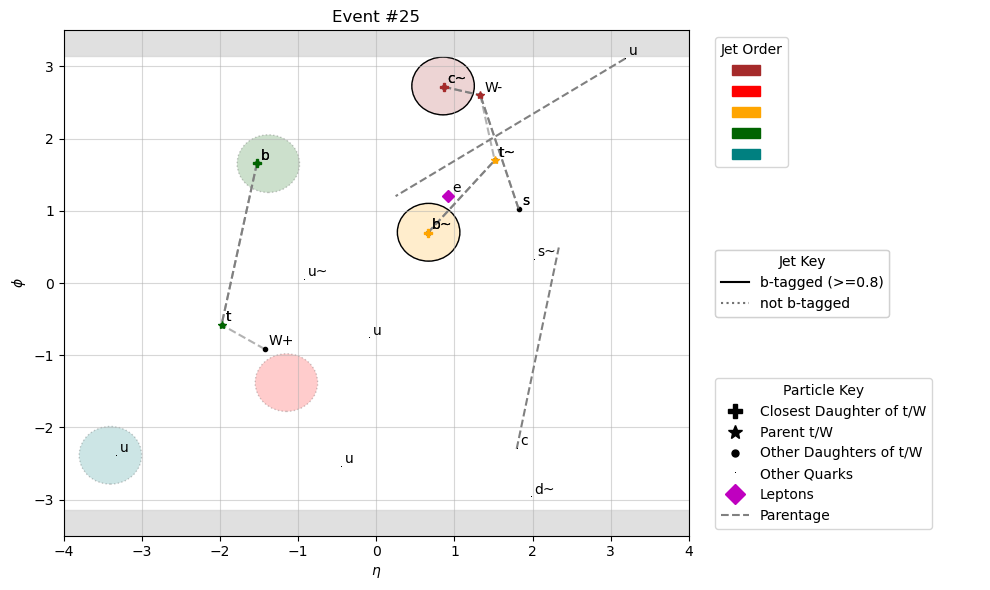

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 26                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   └── s~
│       │       └── c
│       │           ├── c
│       │           └── D*(2010)+
│       │               └── D0
│       │                   └── pi0
│       │                       └── gamma
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   └── D*(2007)0
│                       └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── mu-
│       │       │   ├── mu-
│       │       │   └── gamma
│       │       └── nu(mu)~
│       └── b~
│          

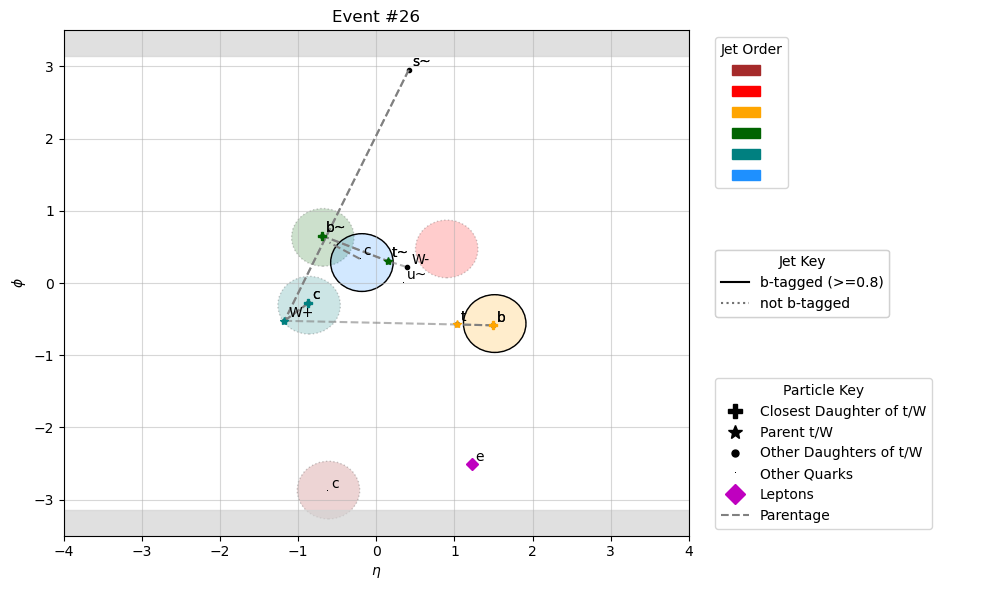

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 27                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── tau+
│       │       │   ├── nu(tau)~
│       │       │   ├── pi+
│       │       │   ├── pi+
│       │       │   └── pi-
│       │       └── nu(tau)
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   └── D*(2007)0
│                       └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   ├── g
│       │       │   ├── g
│       │       │   ├── d
│       │       │   ├── pi0
│       │       │   │   ├── gamma
│       │       │  

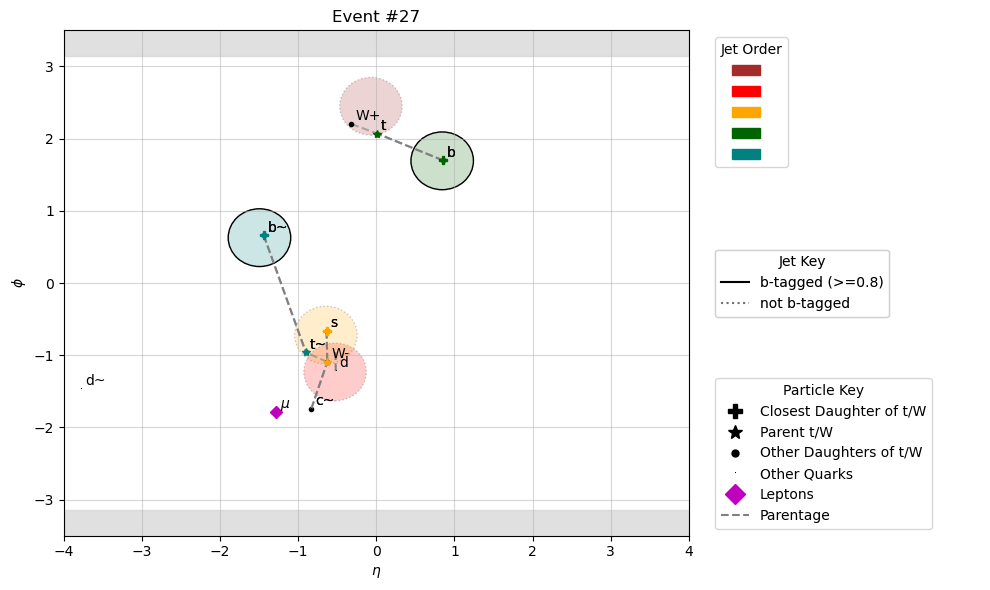

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 28                                         
-----------------------------------------------------------------------------------------------
u
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── s~
│       │       │   ├── D0
│       │       │   └── eta
│       │       │       └── gamma
│       │       └── c
│       │           ├── c
│       │           └── g
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   ├── D+
│                   └── pi0
│                       └── gamma
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   ├── g
│       │       │   ├── g
│       │       │   ├── D(s)-
│       

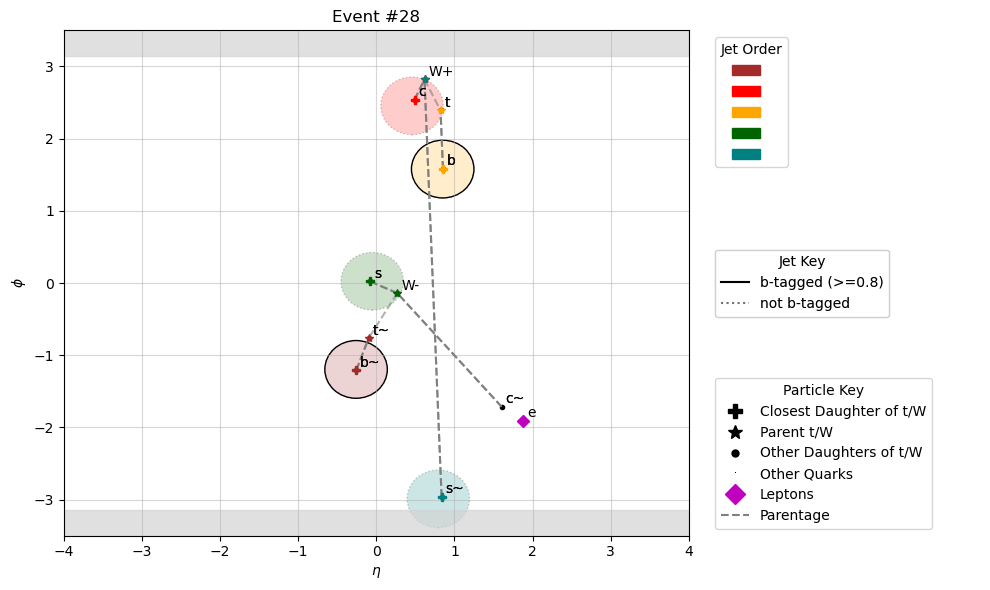

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 29                                         
-----------------------------------------------------------------------------------------------
d~
├── t
│   └── t
│       ├── W+
│       │   ├── e+
│       │   └── nu(e)
│       └── b
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   └── s
│       │       └── c~
│       │           ├── c~
│       │           └── D*(2007)~0
│       │               └── D~0
│       │                   ├── mu-
│       │                   └── nu(mu)~
│       └── b~
│           ├── b~
│           ├── g
│           ├── B*0
│           │   └── B0
│           │       ├── D(s)*+
│           │       │   └── D(s)+
│           │       │       ├── tau+
│           │       │       │   ├── nu(tau

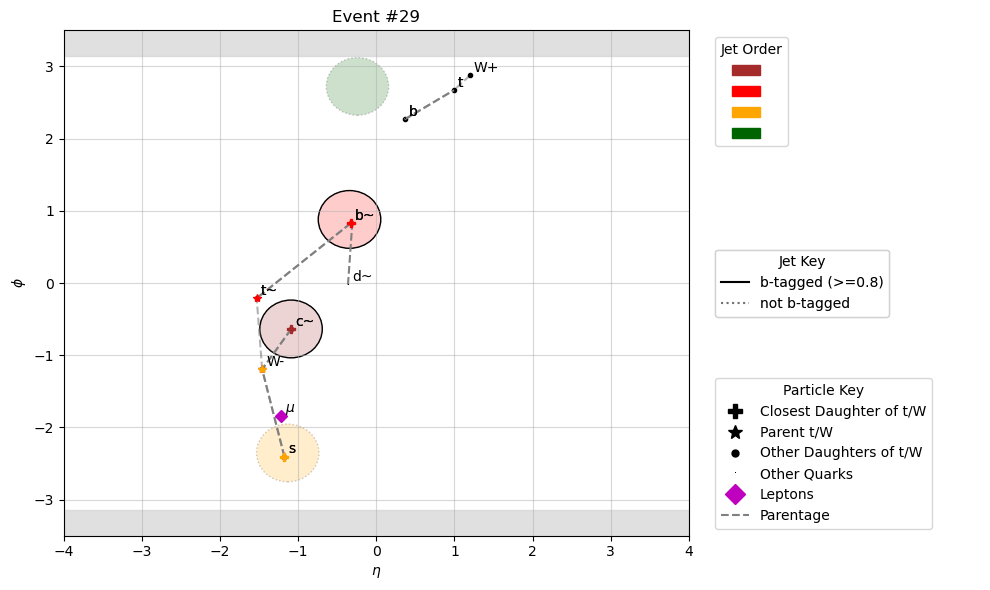

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 30                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── e+
│       │       └── nu(e)
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   ├── D(s)-
│                   └── D*(2010)+
│                       └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   └── D*(2007)~0
│       │       │       └── D~0
│       │       └── c~
│       │           └── c~
│       └── b~
│           ├── b~
│           └── B*0
│               └── B0
│                   ├── D*(2007)0
│                   

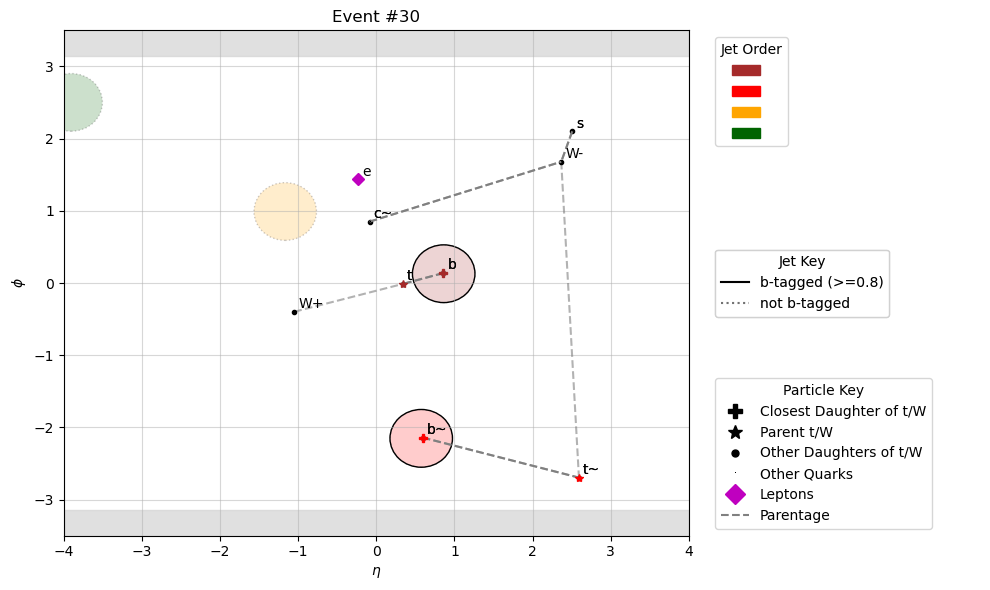

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 31                                         
-----------------------------------------------------------------------------------------------
u
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── g
│       │       │   └── s~
│       │       └── c
│       │           ├── c
│       │           └── D*(2007)0
│       │               └── D0
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   ├── D+
│                   └── pi0
│                       └── gamma
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   ├── d
│       │       │   └── pi0
│       │       │       ├── gamma
│       │       │       └─

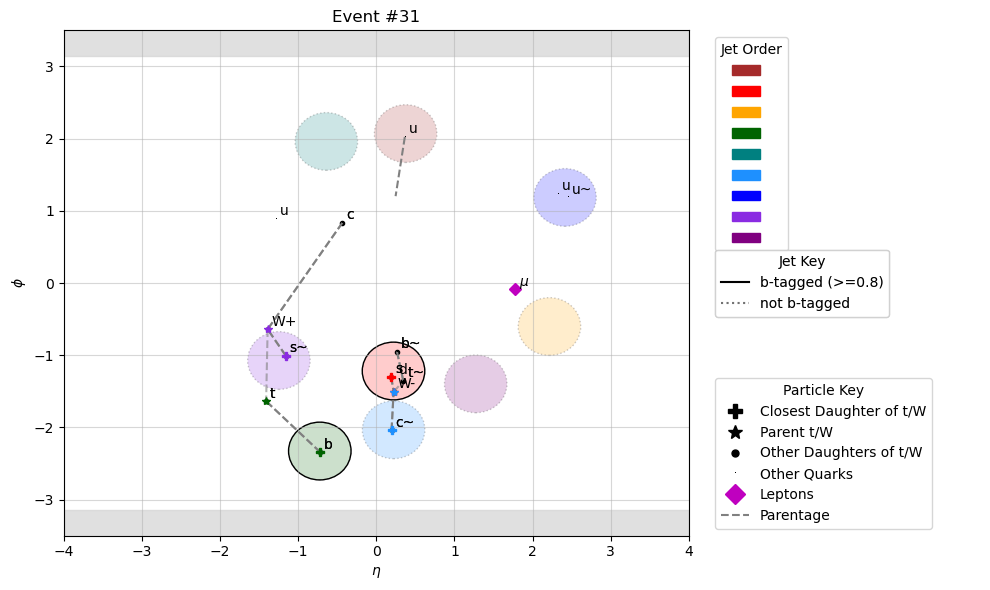

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 32                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   └── s~
│       │       └── c
│       │           ├── c
│       │           ├── g
│       │           └── D0
│       └── b
│           ├── b
│           └── B-
│               └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   └── g
│       │       └── c~
│       │           ├── s
│       │           ├── g
│       │           ├── c~
│       │           └── D~0
│       └── b~
│           ├── b~
│           └── B0
│               ├── D*(2007)0
│    

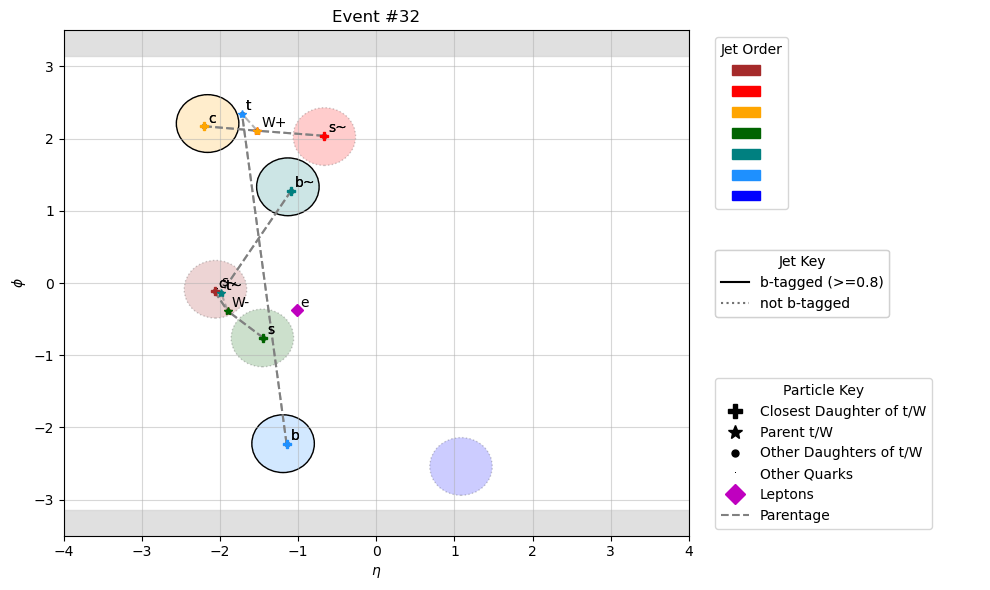

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 33                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── s~
│       │       │   └── D+
│       │       │       ├── mu+
│       │       │       └── nu(mu)
│       │       └── c
│       │           └── c
│       └── b
│           ├── b
│           ├── B(s)*~0
│           │   └── B(s)~0
│           │       ├── nu(e)
│           │       ├── e+
│           │       └── D(s)*-
│           │           └── D(s)-
│           └── D~0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   └── d
│       │       └── u~
│       │           ├── u~
│ 

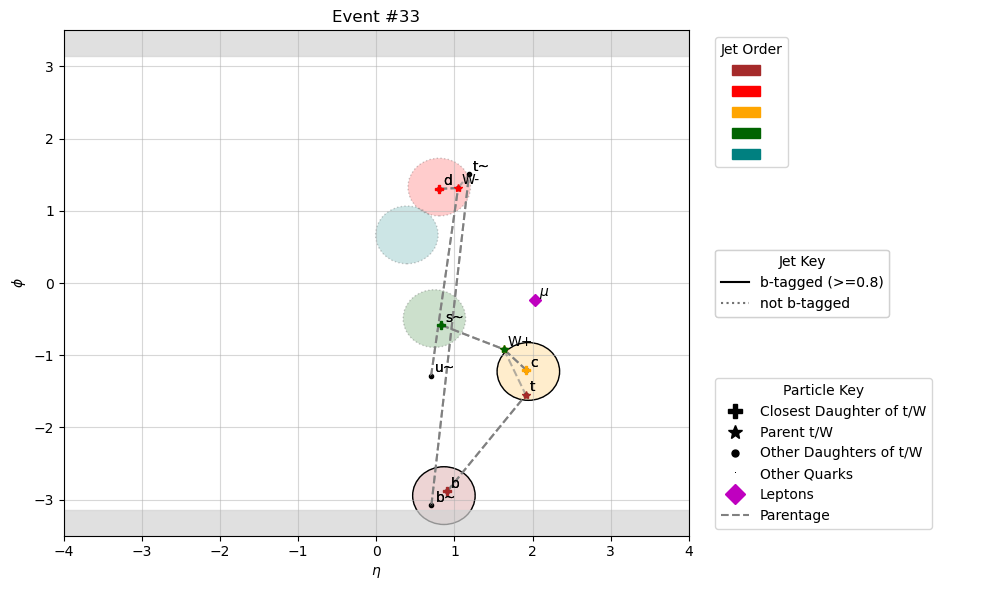

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 34                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── s~
│       │       │   └── Lambda(c)+
│       │       └── c
│       │           └── c
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   ├── D*(2010)+
│                   │   └── D+
│                   └── D-
│                       ├── mu-
│                       └── nu(mu)~
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── e-
│       │       │   └── gamma
│       │       └── nu(e)~
│       └── b~
│           ├── b~
│           └── B+
│             

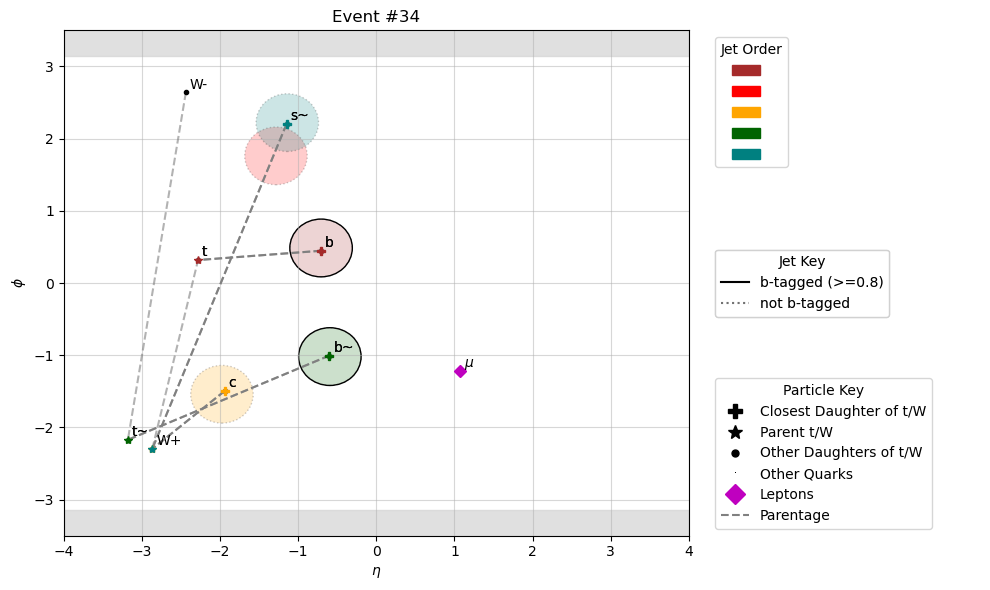

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 35                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   └── s~
│       │       └── c
│       │           ├── c
│       │           └── D0
│       └── b
│           ├── b
│           └── B-
│               ├── D*(2010)-
│               │   └── D~0
│               └── D*(2010)+
│                   └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── mu-
│       │       └── nu(mu)~
│       └── b~
│           ├── b~
│           └── B*+
│               └── B+
│                   ├── nu(e)
│                   ├── e+
│                   └── D*(2007)~0
│    

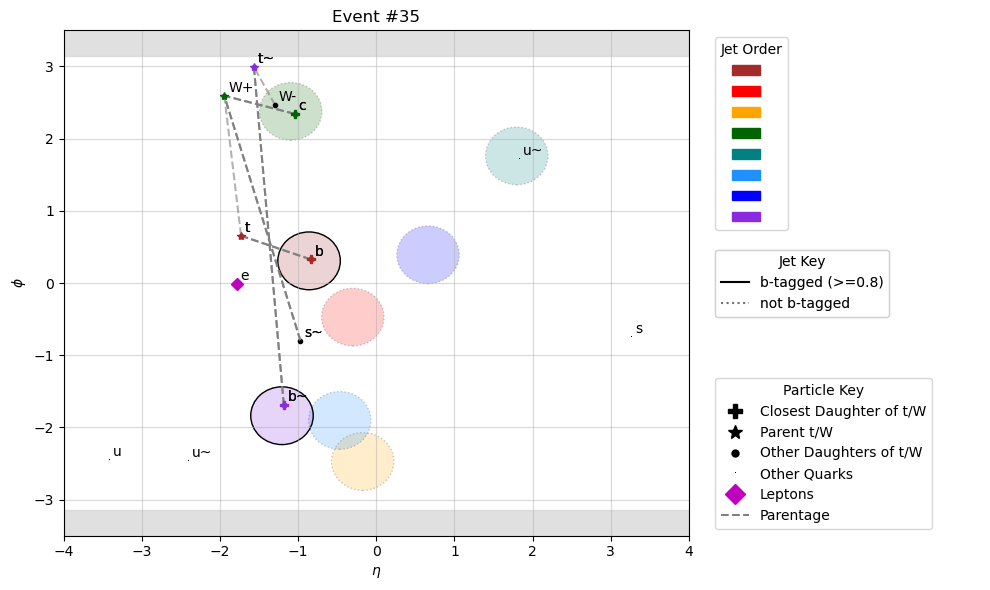

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 36                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── mu+
│       │       └── nu(mu)
│       └── b
│           ├── b
│           │   ├── b
│           │   ├── B*~0
│           │   │   └── B~0
│           │   │       ├── D*(2010)+
│           │   │       │   └── D0
│           │   │       └── D~0
│           │   ├── e-
│           │   └── e+
│           ├── g
│           └── g
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   ├── d
│       │       │   └── pi0
│       │       │       └── gamma
│       │       └── u~
│       │           └── u~
│       └── 

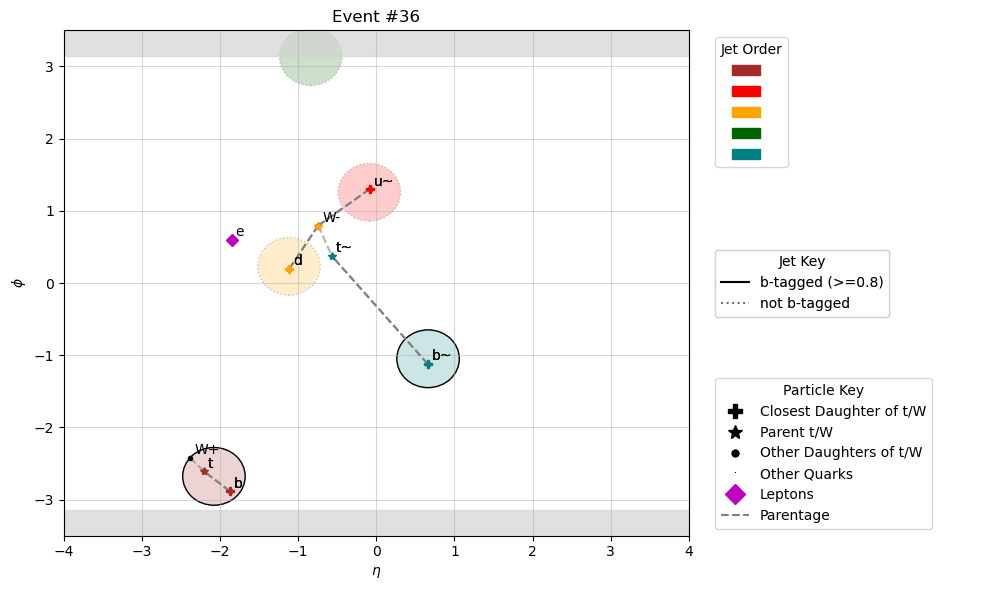

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 37                                         
-----------------------------------------------------------------------------------------------
u
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── d~
│       │       │   └── d~
│       │       └── u
│       │           ├── u
│       │           └── g
│       └── b
│           ├── b
│           └── B(s)*~0
│               └── B(s)~0
│                   └── D(s)*-
│                       └── D(s)-
│                           ├── mu-
│                           └── nu(mu)~
├── t~
│   ├── t~
│   │   ├── W-
│   │   │   ├── tau-
│   │   │   │   ├── nu(tau)
│   │   │   │   ├── pi0
│   │   │   │   │   ├── gamma
│   │   │   │   │   └── gamma
│   │   │   │   ├── pi0
│   │   │   │   │   ├── gamma
│

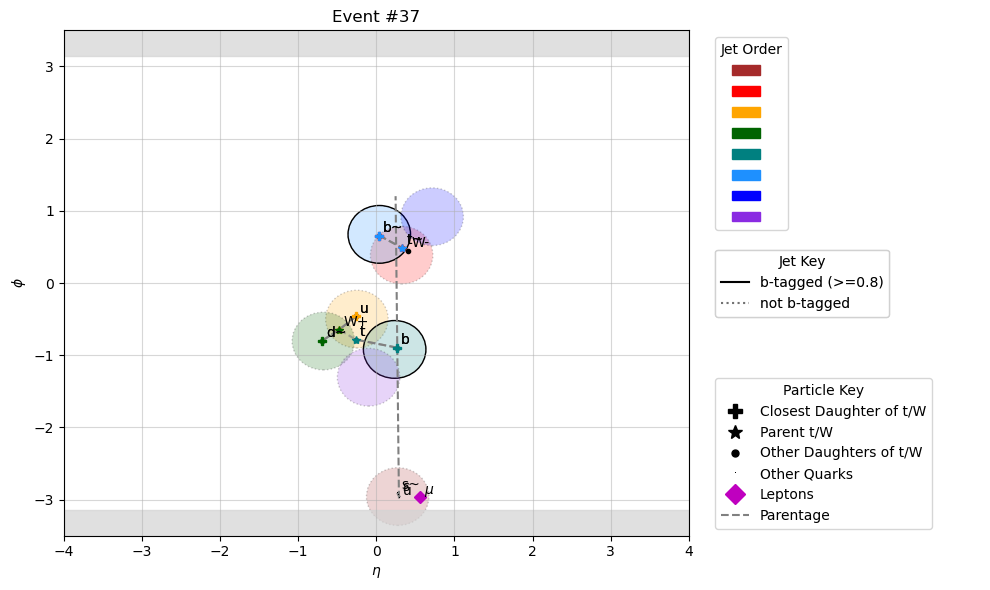

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 38                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── d~
│       │       │   └── d~
│       │       └── u
│       │           └── u
│       └── b
│           ├── b
│           ├── g
│           └── g
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   └── d
│       │       └── u~
│       │           └── u~
│       └── b~
│           ├── b~
│           ├── B*0
│           │   └── B0
│           │       ├── D*(2010)-
│           │       │   └── D~0
│           │       └── D(s)*+
│           │           └── D(s)+
│           ├── e-
│           └── e+
└── g
 

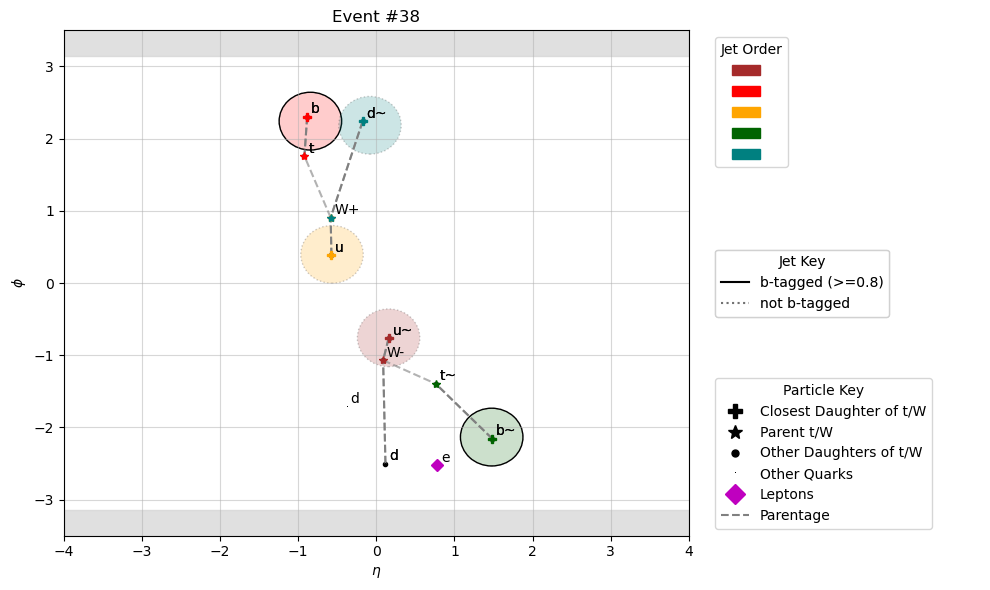

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 39                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── mu+
│       │       └── nu(mu)
│       └── b
│           ├── b
│           └── B*-
│               └── B-
│                   ├── D(s)-
│                   └── D+
├── t~
│   └── t~
│       ├── W-
│       │   ├── d
│       │   │   └── d
│       │   └── u~
│       │       └── u~
│       └── b~
└── g
    └── g
        └── d~
g
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Jet #1:                        

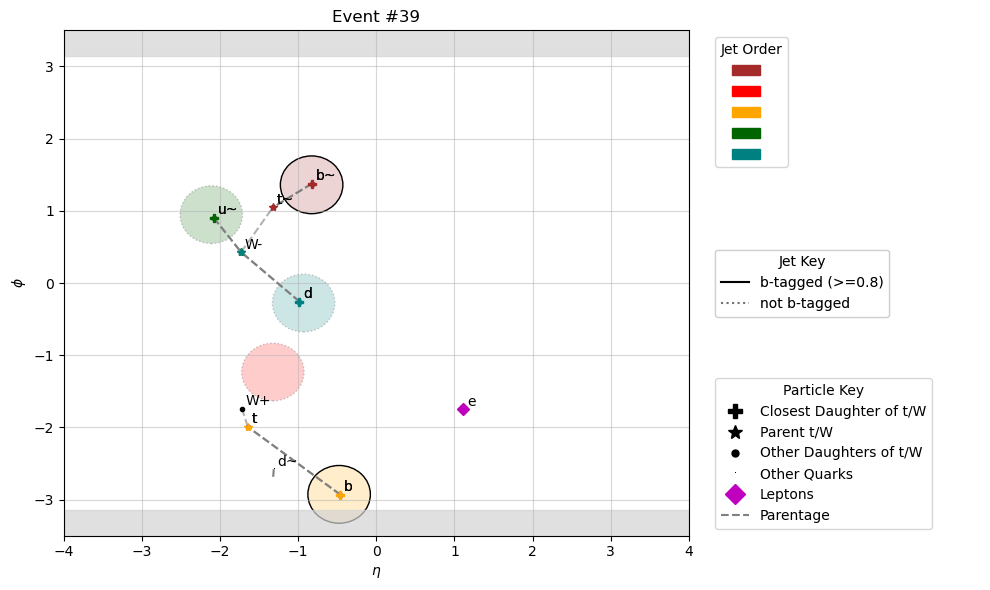

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 40                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       └── b
│           ├── b
│           ├── B*-
│           │   └── B-
│           │       ├── nu(mu)~
│           │       ├── mu-
│           │       └── D*(2007)0
│           │           └── D0
│           ├── B*0
│           │   └── B0
│           │       ├── D*(2010)+
│           │       │   └── D+
│           │       │       ├── e+
│           │       │       └── nu(e)
│           │       └── eta
│           │           └── gamma
│           ├── e-
│           └── e+
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│      

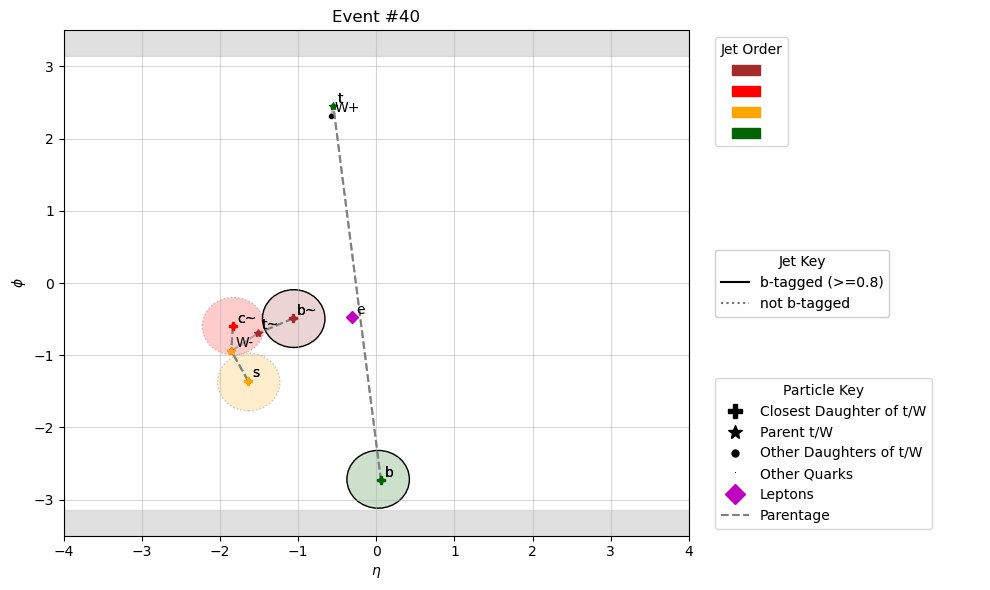

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 41                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── s~
│       │       │   ├── Lambda(c)~-
│       │       │   ├── D+
│       │       │   │   ├── mu+
│       │       │   │   └── nu(mu)
│       │       │   ├── g
│       │       │   └── D*(2010)+
│       │       │       └── D0
│       │       │           ├── e+
│       │       │           └── nu(e)
│       │       └── c
│       │           └── c
│       └── b
│           ├── b
│           └── B-
│               ├── D*(2007)~0
│               │   └── D~0
│               └── D+
├── t~
│   └── t~
│       ├── W-
│       │  

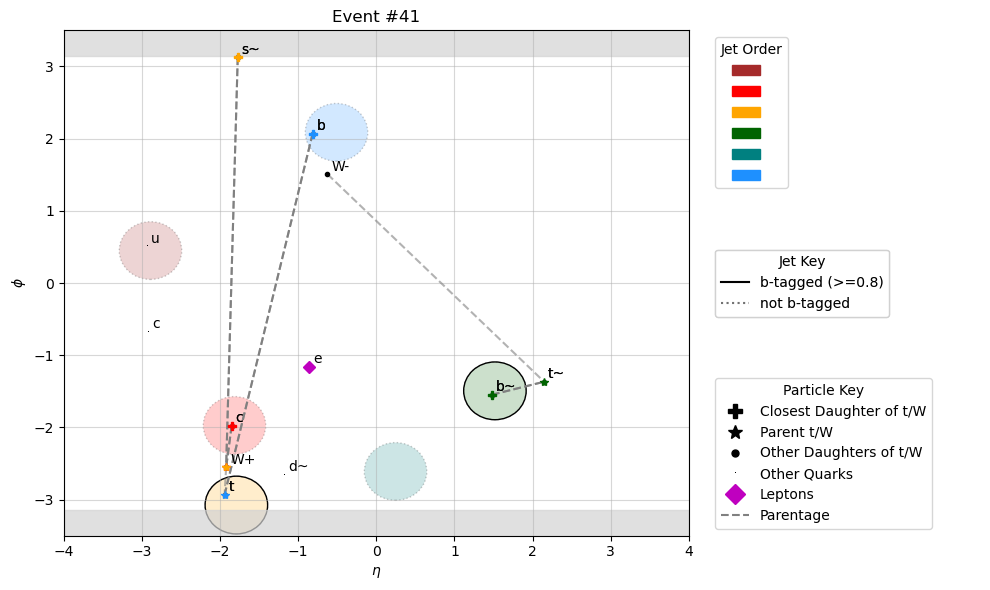

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 42                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── e+
│       │       └── nu(e)
│       └── b
│           ├── b
│           ├── B*~0
│           │   └── B~0
│           │       └── D+
│           └── D*(2007)~0
│               └── D~0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   └── D*(2007)~0
│       │       │       └── D~0
│       │       └── c~
│       │           └── c~
│       └── b~
│           ├── b~
│           └── B*+
│               └── B+
│                   ├── nu(tau)
│                   ├── tau+
│         

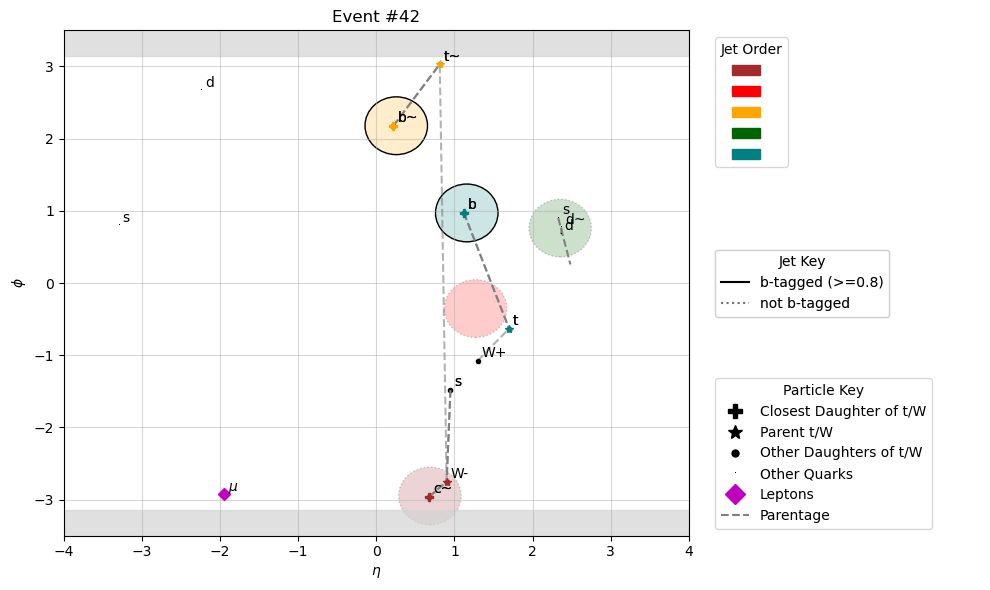

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 43                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       └── b
│           ├── b
│           └── B-
│               ├── nu(tau)~
│               ├── tau-
│               │   ├── nu(tau)
│               │   ├── e-
│               │   └── nu(e)~
│               └── D+
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   ├── s
│       │       │   └── D*(2007)~0
│       │       │       └── D~0
│       │       │           └── pi0
│       │       │               └── gamma
│       │       └── c~
│       │           └── c~
│       └── b~
│           └── b~
└── s
    ├── s
    └── B*0
        └── B

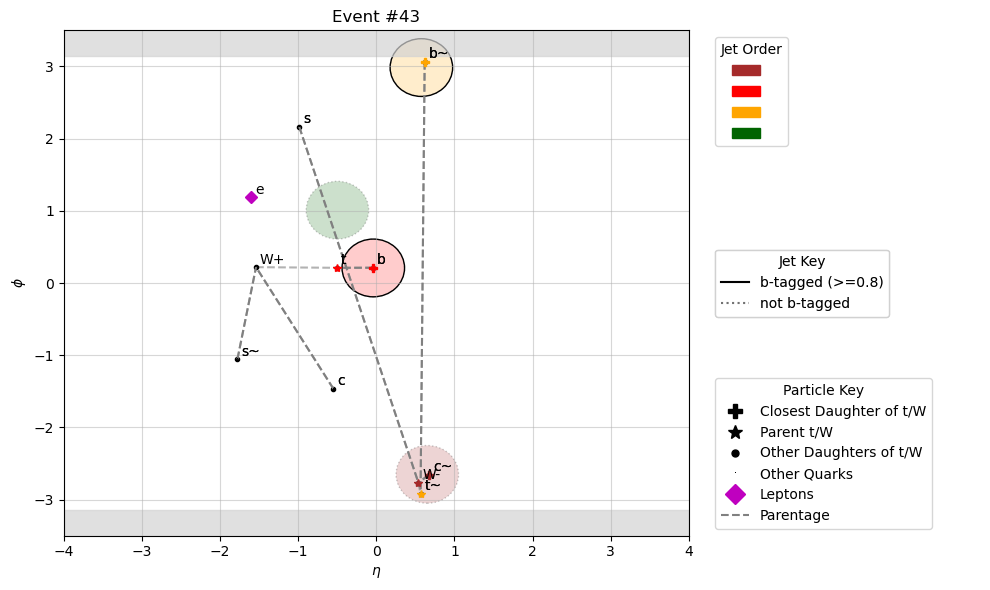

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 44                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── mu+
│       │       └── nu(mu)
│       └── b
│           ├── b
│           ├── B*-
│           │   └── B-
│           │       ├── Xi(c)(2645)+
│           │       │   └── Xi(c)+
│           │       ├── e-
│           │       └── e+
│           ├── e-
│           └── e+
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── tau-
│       │       │   ├── nu(tau)
│       │       │   ├── pi0
│       │       │   │   ├── gamma
│       │       │   │   └── gamma
│       │       │   ├── pi0
│       │       │   │   ├── gamma
│       │   

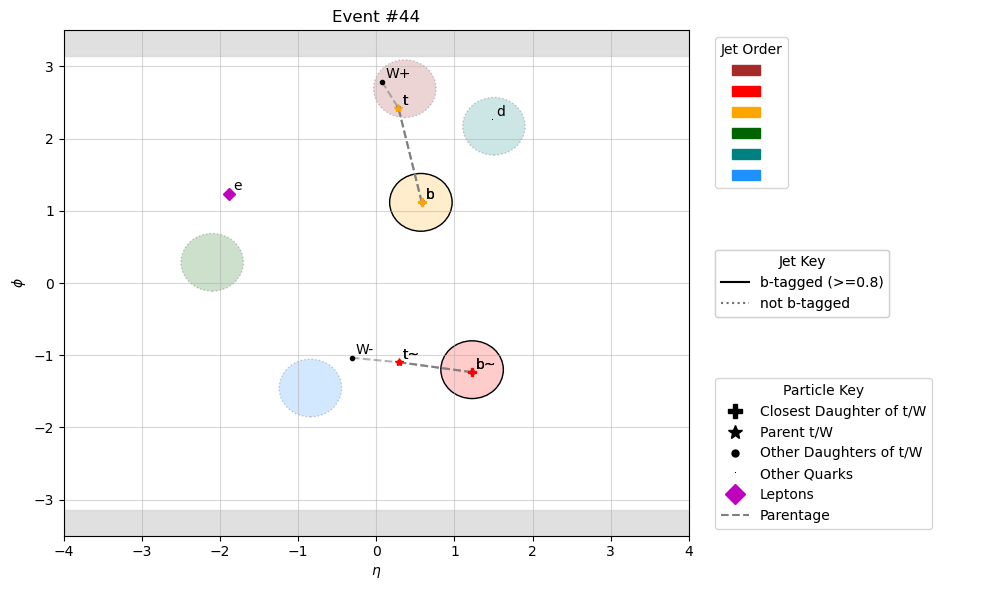

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 45                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── e+
│       │       │   ├── e+
│       │       │   └── gamma
│       │       └── nu(e)
│       └── b
│           ├── b
│           ├── g
│           ├── g
│           └── Lambda(b)0
│               └── Lambda(c)+
├── t~
│   └── t~
│       ├── W-
│       │   ├── d
│       │   │   └── d
│       │   └── u~
│       │       └── u~
│       └── b~
└── g
    ├── g
    │   └── s
    │       ├── B+
    │       │   └── D*(2010)-
    │       │       └── D-
    │       ├── e-
    │       └── e+
    ├── g
    ├── g
    │   └── b~
    ├── g
    ├── g
    ├── 

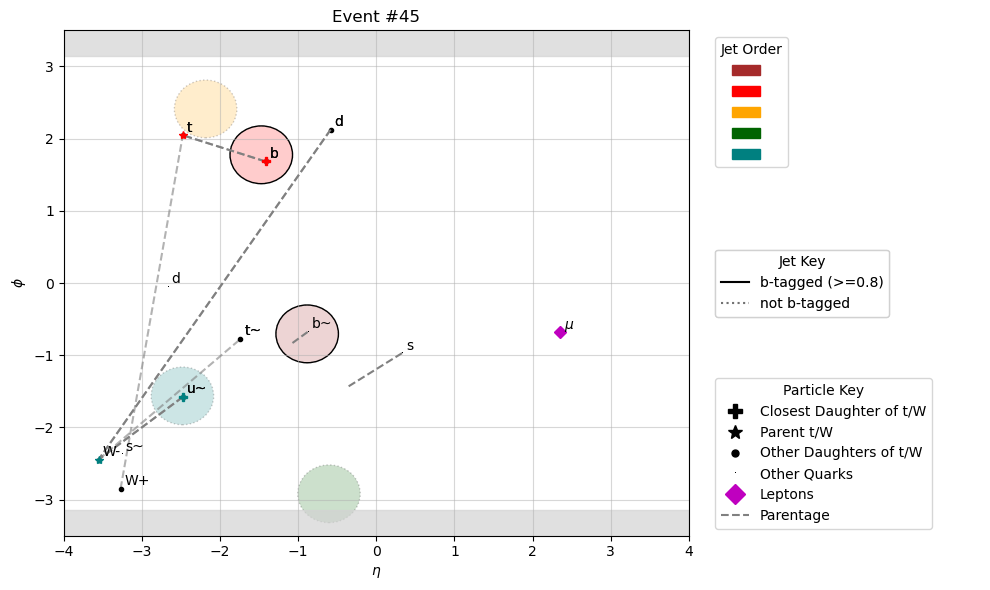

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 46                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── s~
│       │       │   ├── s~
│       │       │   └── D*(2010)+
│       │       │       └── D0
│       │       │           ├── mu+
│       │       │           └── nu(mu)
│       │       └── c
│       │           └── c
│       └── b
│           ├── b
│           └── B(s)~0
│               └── D(s)*+
│                   └── D(s)+
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── d
│       │       │   ├── d
│       │       │   ├── g
│       │       │   ├── e-
│       │       │   └── e+
│       │       └── u~
│       │       

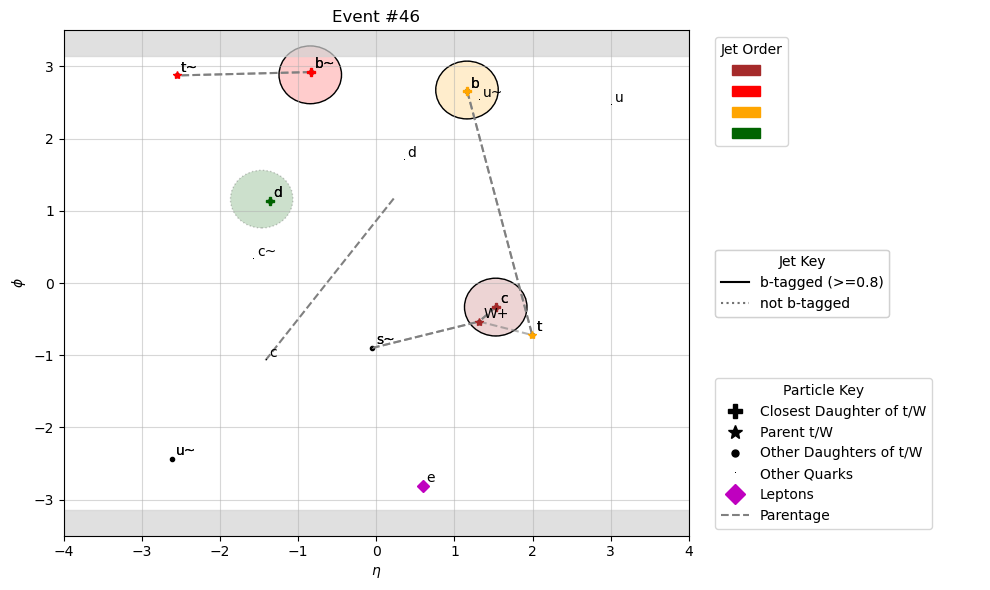

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 47                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       └── b
│           ├── b
│           │   ├── gamma
│           │   └── b
│           └── B-
│               ├── D*(2007)~0
│               │   └── D~0
│               │       ├── e-
│               │       └── e+
│               └── D*(2007)0
│                   └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── s
│       │       │   └── s
│       │       └── c~
│       │           ├── c~
│       │           └── D~0
│       │               ├── mu-
│       │               └── nu(mu)~
│       └── b~
│           ├── b~
│           

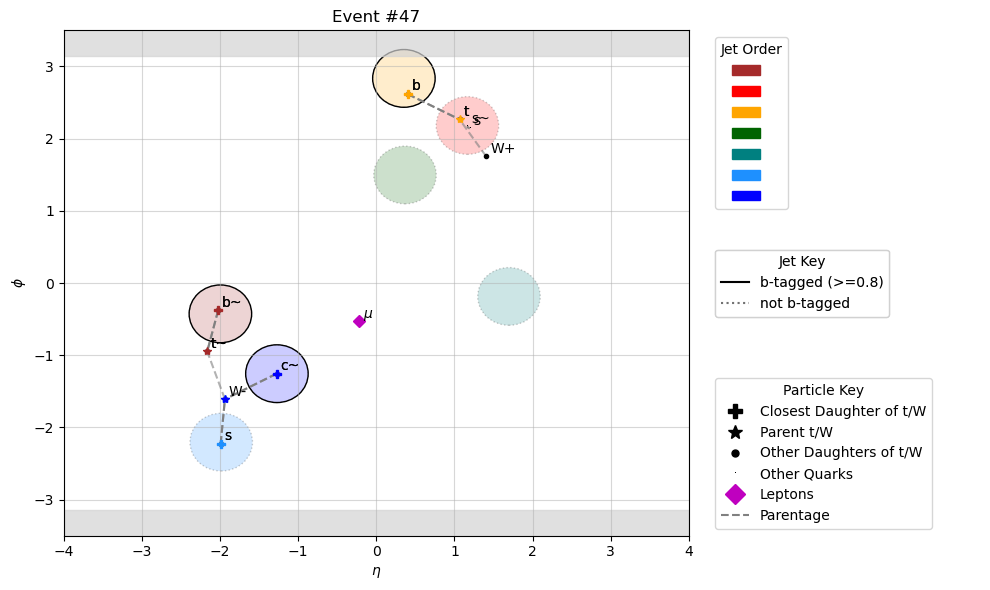

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 48                                         
-----------------------------------------------------------------------------------------------
d
├── t
│   └── t
│       ├── W+
│       │   ├── s~
│       │   │   ├── s~
│       │   │   └── D*(2007)0
│       │   │       └── D0
│       │   └── c
│       │       ├── c
│       │       └── g
│       └── b
├── t~
│   └── t~
│       ├── W-
│       │   ├── mu-
│       │   │   ├── mu-
│       │   │   └── gamma
│       │   └── nu(mu)~
│       └── b~
└── g
    ├── g
    │   ├── D*(2010)+
    │   │   └── D0
    │   ├── B*0
    │   │   └── B0
    │   │       ├── nu(mu)
    │   │       ├── mu+
    │   │       └── D*(2007)~0
    │   │           └── D~0
    │   └── D*(2007)~0
    │       └── D~0
    │           ├── e-
   

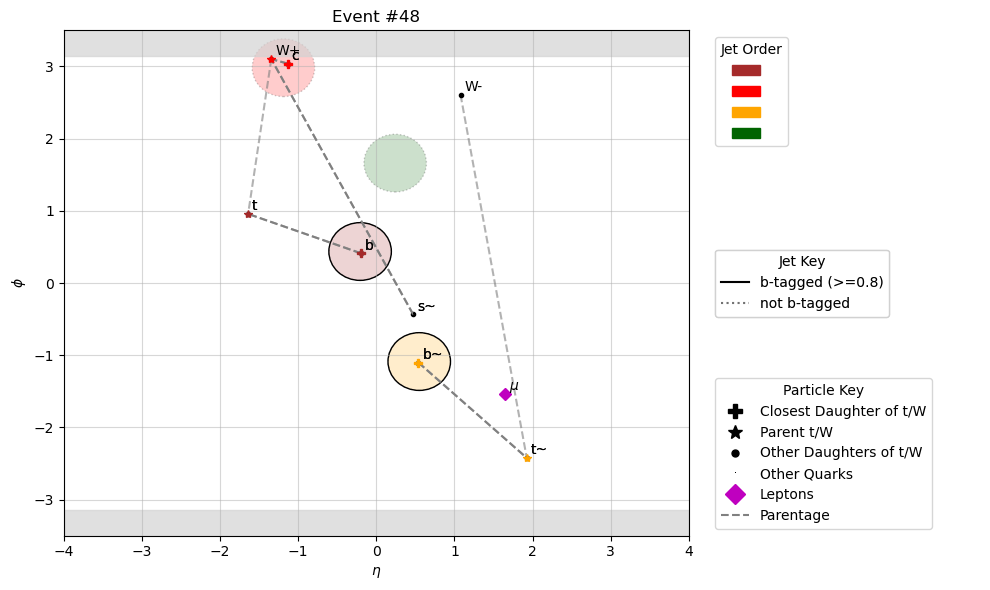

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                                         EVENT 49                                         
-----------------------------------------------------------------------------------------------
g
├── t
│   └── t
│       ├── W+
│       │   └── W+
│       │       ├── d~
│       │       │   ├── d~
│       │       │   ├── pi0
│       │       │   │   └── gamma
│       │       │   ├── e-
│       │       │   └── e+
│       │       └── u
│       │           ├── u
│       │           └── g
│       └── b
│           ├── b
│           └── B*~0
│               └── B~0
│                   └── D*(2010)+
│                       └── D0
├── t~
│   └── t~
│       ├── W-
│       │   └── W-
│       │       ├── e-
│       │       └── nu(e)~
│       └── b~
│           ├── b~
│           └── B*+
│               └── B+
│       

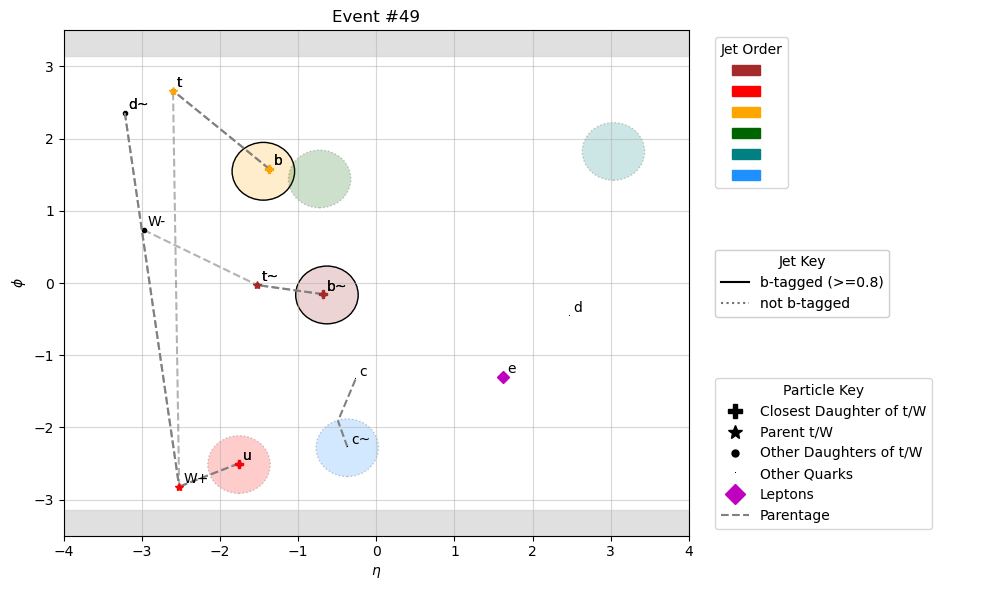

In [10]:
# plot 50 events
for iEvt in range(50):
    
    print("-----------------------------------------------------------------------------------------------")
    print("-----------------------------------------------------------------------------------------------")
    print(f"                                         EVENT {iEvt}                                         ")
    print("-----------------------------------------------------------------------------------------------")
    # print event tree from genParticles
    printTrees(selected_genpart_region[iEvt])
    print("-----------------------------------------------------------------------------------------------")
    
    # define mpl figure
    fig,axs = plt.subplots(1,2,figsize=(10,6),gridspec_kw={'width_ratios': [2.3, 1]})
    
    # get eta and phi t/W and their quark daughters
    genpart_eta = plotting_candidates[iEvt].eta[(np.abs(plotting_candidates[iEvt].eta)<4)
                                                & (np.abs(plotting_candidates[iEvt].phi)<=np.pi)]
    genpart_phi = plotting_candidates[iEvt].phi[(np.abs(plotting_candidates[iEvt].eta)<4)
                                                & (np.abs(plotting_candidates[iEvt].phi)<=np.pi)]
    
    # print particle name and draw lines to parents
    for i in range(len(plotting_candidates[iEvt])):
        
        # if in range
        if ((np.abs(plotting_candidates[iEvt][i].eta)<4) & 
            (np.abs(plotting_candidates[iEvt][i].phi)<=np.pi)):
            
            # print text
            axs[0].text(plotting_candidates[iEvt][i].eta+0.05, 
                        plotting_candidates[iEvt][i].phi+0.05, 
                        f"{particle.Particle.from_pdgid(plotting_candidates[iEvt][i].pdgId).name}", 
                        fontsize=10)
        
            # if parent exists
            if not plotting_candidates[iEvt][i].distinctParent is None and not plotting_candidates[iEvt][i].genPartIdxMother==-1:

                # if in range
                if ((np.abs(plotting_candidates[iEvt][i].distinctParent.eta)<4) & 
                    (np.abs(plotting_candidates[iEvt][i].distinctParent.phi)<=np.pi)):

                    # draw line between particle and parent
                    axs[0].plot([plotting_candidates[iEvt][i].eta, 
                                 plotting_candidates[iEvt][i].distinctParent.eta],
                                [plotting_candidates[iEvt][i].phi, 
                                 plotting_candidates[iEvt][i].distinctParent.phi],
                                marker=None, linestyle='dashed', color='grey', alpha=0.6)
                
    # plot t/W and their daughter quarks
    axs[0].plot(genpart_eta, genpart_phi, 'k.')
    
    # print particle name and draw lines to parents (all quarks)
    for i in range(len(all_quarks[iEvt])):
        
        # if in range
        if ((np.abs(all_quarks[iEvt][i].eta)<4) & (np.abs(all_quarks[iEvt][i].phi)<=np.pi)):
            
            # print text
            axs[0].text(all_quarks[iEvt][i].eta+0.05, 
                        all_quarks[iEvt][i].phi+0.05, 
                        f"{particle.Particle.from_pdgid(all_quarks[iEvt][i].pdgId).name}", 
                        fontsize=10)
            
            # if parent exists
            if not all_quarks[iEvt][i].distinctParent is None and not all_quarks[iEvt][i].genPartIdxMother==-1:
                
                # if in range
                if ((np.abs(all_quarks[iEvt][i].distinctParent.eta)<4) & 
                    (np.abs(all_quarks[iEvt][i].distinctParent.phi)<=np.pi)):

                    # draw line between quark and parent
                    axs[0].plot([all_quarks[iEvt][i].eta, all_quarks[iEvt][i].distinctParent.eta],
                                [all_quarks[iEvt][i].phi, all_quarks[iEvt][i].distinctParent.phi],
                                marker=None, linestyle='dashed', color='grey')
      
    # grab quark eta and phi
    quark_eta = all_quarks[iEvt].eta[(np.abs(all_quarks[iEvt].eta)<4) & (np.abs(all_quarks[iEvt].phi)<=np.pi)]
    quark_phi = all_quarks[iEvt].phi[(np.abs(all_quarks[iEvt].eta)<4) & (np.abs(all_quarks[iEvt].phi)<=np.pi)]
        
    # plot quarks
    axs[0].plot(quark_eta, quark_phi, 'k,')
    
    order_elements = [] # store jet color patches for legend
    
    # iterate through jets
    for i,jet in enumerate(selected_jets_region[iEvt]):
        
        # print jet information
        print("-----------------------------------------------------------------------------------------------")
        print(f"Jet #{i+1}:                         ({jet.eta}, {jet.phi})")
        
        
        # create circle centered around jet center with R=0.4
        circle = plt.Circle((jet.eta, jet.phi), 0.4, facecolor=jetcolors[i], edgecolor = 'k', linestyle='dotted', alpha=0.2)
        
        # if matched to a GenPart
        if not nearest_genpart[iEvt][i] is None:
            
            # print matched particle info
            print(f"Closest GenPart ({particle.Particle.from_pdgid(nearest_genpart[iEvt][i].pdgId).name}):            ({nearest_genpart[iEvt][i].eta}, {nearest_genpart[iEvt][i].phi})")
            
            # plot matched particle
            axs[0].plot(nearest_genpart[iEvt][i].eta, nearest_genpart[iEvt][i].phi, 'P', color=jetcolors[i]) 
            
        # if matched to a GenPart which has a valid parent
        if not nearest_parent[iEvt][i] is None:
            
            # print parent info
            print(f"Parent of Closest GenPart ({particle.Particle.from_pdgid(nearest_parent[iEvt][i].pdgId).name}): ({nearest_parent[iEvt][i].eta}, {nearest_parent[iEvt][i].phi})")
            
            # plot parent
            axs[0].plot(nearest_parent[iEvt][i].eta, nearest_parent[iEvt][i].phi, '*', color=jetcolors[i]) 
    
        # add circle to mpl axis
        axs[0].add_patch(circle)
        
        # add border if b-tagged
        if jet.btagCSVV2>0.8:
            circle = plt.Circle((jet.eta, jet.phi), 0.4, facecolor=None, edgecolor = 'k', 
                                linestyle='solid', fill=False)
            axs[0].add_patch(circle)
        
        # add jet color info for legend
        order_elements.append(Patch(facecolor=jetcolors[i], edgecolor=jetcolors[i],label=''))
        
    # plot electrons
    axs[0].plot(selected_electrons[iEvt].eta, selected_electrons[iEvt].phi, 'mD')
    for i in range(len(selected_electrons[iEvt])):
        axs[0].text(selected_electrons[iEvt][i].eta+0.05, selected_electrons[iEvt][i].phi+0.05, "e", fontsize=10)
    
    # plot muons
    axs[0].plot(selected_muons[iEvt].eta, selected_muons[iEvt].phi, 'mD')
    for i in range(len(selected_muons[iEvt])):
        axs[0].text(selected_muons[iEvt][i].eta+0.05, selected_muons[iEvt][i].phi+0.05, "$\mu$", fontsize=10)
    
    # legend for jet order
    legend1 = plt.legend(handles=order_elements, 
                         title="Jet Order", 
                         loc='upper left')
    
    # legend for particles
    particle_legend_elements = [Line2D([0], [0], marker='P', color='k', label='Closest Daughter of t/W', 
                                       markersize=10, linestyle='None'),
                                Line2D([0], [0], marker='*', color='k', label='Parent t/W', 
                                       markersize=10, linestyle='None'),
                                Line2D([0], [0], marker='.', color='k', label='Other Daughters of t/W', 
                                       markersize=10, linestyle='None'),
                                Line2D([0], [0], marker=',', color='k', label='Other Quarks', 
                                       markersize=10, linestyle='None'),
                                Line2D([0], [0], marker='D', color='m', label='Leptons', 
                                       markersize=10, linestyle='None'),
                                Line2D([0], [0], marker=None, color='gray', label='Parentage', 
                                       linestyle='dashed')]
    
    legend2 = plt.legend(handles=particle_legend_elements, 
                         title="Particle Key", 
                         loc='lower left')
    
    # legend for jets
    jet_legend_elements = [Line2D([0], [0], marker=None, color='k', label='b-tagged (>=0.8)', 
                                  linestyle='solid',alpha=1.0),
                           Line2D([0], [0], marker=None, color='k', label='not b-tagged', 
                                  linestyle='dotted',alpha=0.5)]
    
    legend3 = plt.legend(handles=jet_legend_elements, 
                         title="Jet Key", 
                         loc='center left')
    
    # marks pi and -pi on plot
    # axs[0].hlines([-np.pi, np.pi], -4, 4, color='lightgray', alpha=0.5, linewidth=5)
    
    # add legends to plot
    axs[1].add_artist(legend1)
    axs[1].add_artist(legend2)
    axs[1].add_artist(legend3)
    
    # plotting limits
    axs[0].set_xlim([-4,4])
    axs[0].set_ylim([-3.5,3.5])
    
    # set axis labels
    axs[0].set_xlabel("$\eta$")
    axs[0].set_ylabel("$\phi$")
    
    axs[0].grid(alpha=0.5)
    axs[0].set_title(f"Event #{iEvt}")
    
    # make second subplot invisible (just used to get legends to show up nicely)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].get_xaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks([])
    
    # shade areas outside phi=(-pi,pi)
    axs[0].fill_between([-4,4],np.pi,np.pi+1,color='lightgray',alpha=0.7)
    axs[0].fill_between([-4,4],-1-np.pi,-np.pi,color='lightgray',alpha=0.7)
    
    fig.tight_layout()
    
    print("-----------------------------------------------------------------------------------------------")
    plt.show()